In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

1

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
from pycmqlib3.utility import dbaccess, dataseries, misc
from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams['figure.figsize'] = (12, 8)


In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# define product groups and start times

In [5]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

In [6]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2023, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


# load historical data

In [7]:
fields = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

start_date = datetime.date(2010,1,1)
end_date = datetime.date(2023,4,24)
shift_mode = 2
roll_name = 'hot'
roll_file_loc = "C:/dev/wtdev/config/"
sim_markets = all_markets
nb_cont = 2
freq='d1'

data_df = pd.DataFrame()

for prodcode in sim_markets:
    for nb in range(nb_cont):
        xdf = dataseries.nearby(prodcode,
                                nb+1,
                                start_date=start_date, 
                                end_date = end_date, 
                                shift_mode = shift_mode,
                                freq=freq, 
                                roll_name=roll_name, 
                                config_loc=roll_file_loc)
        xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
        xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
        xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
        xdf['product'] = prodcode
        xdf['code'] = f'c{nb+1}'
        data_df = data_df.append(xdf)

df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = list(fields), aggfunc = 'last')
df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
df.columns.rename(['product', 'code', 'field',], inplace = True)
df.index = pd.to_datetime(df.index)
df.tail(5)

product         AP                                                         \
code            c1                                                          
field        close contract  diff_oi      expiry    high     low      mth   
date                                                                        
2023-04-18  8244.0   AP2310    683.0  2023-10-20  8293.0  8191.0  24286.0   
2023-04-19  8408.0   AP2310  20969.0  2023-10-20  8495.0  8223.0  24286.0   
2023-04-20  8438.0   AP2310 -10165.0  2023-10-20  8479.0  8385.0  24286.0   
2023-04-21  8458.0   AP2310  15303.0  2023-10-20  8553.0  8310.0  24286.0   
2023-04-24  8546.0   AP2310  18471.0  2023-10-20  8738.0  8531.0  24286.0   

product                                                                   \
code                                                 c2                    
field         open openInterest shift    volume   close contract diff_oi   
date                                                                       
2023-04-18  8226.0     122517.0   0.0   66873.0  8124.0   AP2311   104.0   
2023-04-19  8253.0     143486.0   0.0  188829.0  8283.0   AP2311   249.0   
2023-04-20  8410.0     133321.0   0.0  109103.0  8289.0   AP2311    78.0   
2023-04-21  8438.0     148624.0   0.0  189878.0  8302.0   AP2311     3.0   
2023-04-24  8600.0     167095.0   0.0  267293.0  8402.0   AP2311   346.0   

product                                                                     \
code                                                                         
field           expiry    high     low      mth    open openInterest shift   
date                                                                         
2023-04-18  2023-11-14  8180.0  8089.0  24287.0  8136.0      11956.0   0.0   
2023-04-19  2023-11-14  8354.0  8109.0  24287.0  8136.0      12205.0   0.0   
2023-04-20  2023-11-14  8332.0  8260.0  24287.0  8307.0      12283.0   0.0   
2023-04-21  2023-11-14  8400.0  8180.0  24287.0  8310.0      12286.0   0.0   
2023-04-24  2023-11-14  8585.0  8390.0  24287.0  8423.0      12632.0   0.0   

product                  CF                                                  \
code                     c1                                                   
field       volume    close contract  diff_oi      expiry     high      low   
date                                                                          
2023-04-18   726.0  15145.0   CF2309  20294.0  2023-09-14  15165.0  15045.0   
2023-04-19  1021.0  15160.0   CF2309   7915.0  2023-09-14  15230.0  15100.0   
2023-04-20   400.0  15175.0   CF2309   4280.0  2023-09-14  15215.0  15085.0   
2023-04-21   517.0  14855.0   CF2309 -30989.0  2023-09-14  15100.0  14780.0   
2023-04-24  1351.0  14895.0   CF2309    810.0  2023-09-14  14945.0  14740.0   

product                                                                      \
code                                                            c2            
field           mth     open openInterest shift    volume    close contract   
date                                                                          
2023-04-18  24285.0  15105.0     621373.0   0.0  359588.0  15415.0   CF2401   
2023-04-19  24285.0  15150.0     629288.0   0.0  413602.0  15440.0   CF2401   
2023-04-20  24285.0  15150.0     633568.0   0.0  445291.0  15460.0   CF2401   
2023-04-21  24285.0  15080.0     602579.0   0.0  697293.0  15150.0   CF2401   
2023-04-24  24285.0  14860.0     603389.0   0.0  448096.0  15175.0   CF2401   

product                                                             \
code                                                                 
field      diff_oi      expiry     high      low      mth     open   
date                                                                 
2023-04-18  5139.0  2024-01-12  15430.0  15300.0  24289.0  15350.0   
2023-04-19  7650.0  2024-01-12  15495.0  15375.0  24289.0  15455.0   
2023-04-20  5334.0  2024-01-12  15500.0  15370.0  24289.0  15425.0   
2023

In [8]:
for prodcode in sim_markets:
    if shift_mode == 1:
        df[(prodcode, 'c1', 'ryield')]= np.log(df[(prodcode, 'c1', 'close')] - df[(prodcode, 'c1', 'shift')]) - \
                                            np.log(df[(prodcode, 'c2', 'close')] - df[(prodcode, 'c2', 'shift')])
        df[(prodcode, 'c1', 'pct_chg')] = (df[(prodcode, 'c1', 'close')] - df[(prodcode, 'c1', 'shift')])/(df[(prodcode, 'c1', 'close')].shift(1) - df[(prodcode, 'c1', 'shift')]) - 1
        df[(prodcode, 'c1', 'lr')] = np.log(1 + df[(prodcode, 'c1', 'pct_chg')])
    elif shift_mode == 0:
        df[(prodcode, 'c1', 'ryield')] = np.log(df[(prodcode, 'c1', 'close')])-np.log(df[(prodcode, 'c2', 'close')])
        df[(prodcode, 'c1', 'pct_chg')] = df[(prodcode, 'c1', 'close')].pct_change()
        df[(prodcode, 'c1', 'lr')] = np.log(1 + df[(prodcode, 'c1', 'pct_chg')])
    elif shift_mode == 2:
        df[(prodcode, 'c1', 'ryield')]= np.log(df[(prodcode, 'c1', 'close')])-np.log(df[(prodcode, 'c2', 'close')]) - \
                                            df[(prodcode, 'c1', 'shift')] + df[(prodcode, 'c2', 'shift')]
        df[(prodcode, 'c1', 'pct_chg')] = df[(prodcode, 'c1', 'close')].pct_change()
        df[(prodcode, 'c1', 'lr')] = np.log(1 + df[(prodcode, 'c1', 'pct_chg')])
    df[(prodcode, 'c1', 'px_chg')] = df[(prodcode, 'c1', 'close')].diff()
    df[(prodcode, 'c1', 'ryield')] = df[(prodcode, 'c1', 'ryield')]/(df[(prodcode, 'c2', 'mth')] - df[(prodcode, 'c1', 'mth')])*12.0
adf = df.copy(deep=True)


C:\Users\harvey\AppData\Local\Temp/ipykernel_31500/332754688.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[(prodcode, 'c1', 'lr')] = np.log(1 + df[(prodcode, 'c1', 'pct_chg')])
C:\Users\harvey\AppData\Local\Temp/ipykernel_31500/332754688.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[(prodcode, 'c1', 'px_chg')] = df[(prodcode, 'c1', 'close')].diff()
C:\Users\harvey\AppData\Local\Temp/ipykernel_31500/332754688.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

# Calculate features

In [10]:
product_list = ['rb', 'hc', 'i', 'j', 'jm', 'cu', 'al', 'zn', 'v', 'UR', 'FG', 'ni', 'sn', 'ss', ] # 'ag', 'p', 'y', 'OI'

xdf = adf.loc[:, (adf.columns.get_level_values(1)=='c1') & adf.columns.get_level_values(0).isin(product_list)].copy()
xdf=xdf['2011-01-01':]
xdf.tail(5)

product         FG                                                         \
code            c1                                                          
field        close contract  diff_oi      expiry    high     low      mth   
date                                                                        
2023-04-18  1770.0   FG2309  36746.0  2023-09-14  1774.0  1741.0  24285.0   
2023-04-19  1778.0   FG2309  -9346.0  2023-09-14  1803.0  1766.0  24285.0   
2023-04-20  1850.0   FG2309  80651.0  2023-09-14  1867.0  1771.0  24285.0   
2023-04-21  1807.0   FG2309 -76378.0  2023-09-14  1906.0  1797.0  24285.0   
2023-04-24  1837.0   FG2309  10078.0  2023-09-14  1866.0  1770.0  24285.0   

product                                               UR                    \
code                                                  c1                     
field         open openInterest shift     volume   close contract  diff_oi   
date                                                                         
2023-04-18  1761.0    1156552.0   0.0   943156.0  2093.0   UR2309  -7003.0   
2023-04-19  1775.0    1147206.0   0.0  1541234.0  2077.0   UR2309   6114.0   
2023-04-20  1772.0    1227857.0   0.0  2069181.0  2088.0   UR2309  10736.0   
2023-04-21  1860.0    1151479.0   0.0  3619531.0  2034.0   UR2309   4420.0   
2023-04-24  1811.0    1161557.0   0.0  3281080.0  2016.0   UR2309   7202.0   

product                                                                     \
code                                                                         
field           expiry    high     low      mth    open openInterest shift   
date                                                                         
2023-04-18  2023-09-14  2098.0  2051.0  24285.0  2052.0     187170.0   0.0   
2023-04-19  2023-09-14  2108.0  2073.0  24285.0  2098.0     193284.0   0.0   
2023-04-20  2023-09-14  2092.0  2031.0  24285.0  2065.0     204020.0   0.0   
2023-04-21  2023-09-14  2085.0  2021.0  24285.0  2080.0     208440.0   0.0   
2023-04-24  2023-09-14  2042.0  1989.0  24285.0  2025.0     215642.0   0.0   

product                    al                                              \
code                       c1                                               
field         volume    close contract  diff_oi      expiry          high   
date                                                                        
2023-04-18  204057.0  18990.0   al2305    649.0  2023-05-15  18994.997368   
2023-04-19  190988.0  19030.0   al2306  45862.0  2023-06-15  19080.000000   
2023-04-20  260167.0  19205.0   al2306  48634.0  2023-06-15  19275.000000   
2023-04-21  292636.0  18890.0   al2306 -24948.0  2023-06-15  19270.000000   
2023-04-24  269621.0  18835.0   al2306  -2815.0  2023-06-15  19030.000000   

product                                                                 \
code                                                                     
field                low      mth          open openInterest     shift   
date                                                                     
2023-04-18  18730.136842  24281.0  18770.115789     173335.0 -0.000526   
2023-04-19  18945.000000  24282.0  19035.000000     242124.0  0.000000   
2023-04-20  18975.000000  24282.0  19000.000000     290758.0  0.000000   
2023-04-21  18850.000000  24282.0  19180.000000     265810.0  0.000000   
2023-04-24  18820.000000  24282.0  18960.000000     262995.0  0.000000   

product                         cu                                \
code                            c1                                 
field         volume         close contract  diff_oi      expiry   
date                                                               
2023-04-18  144967.0  69689.441961   cu2305 -14302.0  2023-05-15   
2023-04-19  248535.0  69379.844268   cu2305  -9551.0  2023-05-15   
2023-04-20  252335.0  69260.000000   cu2305 -13321.0  2023-05-15   
2023-04-21  315041.0  68570.000000   cu2306   5542.0  2023-06-1

In [11]:
signal_raw = pd.DataFrame(index=xdf.index)
#signal_raw['rb_hc_diff'] = (xdf[('hc', 'c1', 'px_chg')] - xdf[('rb', 'c1', 'px_chg')]).cumsum()
for asset in product_list:
    signal_raw[f'{asset}_px'] = xdf[(asset, 'c1', 'close')]
    
# signal_raw['sc_px'] = xdf[('sc', 'c1', 'close')]
# signal_raw['TA_px'] = xdf[('TA', 'c1', 'close')]
feature_list = signal_raw.columns


In [12]:
signal_list = []

for feature in feature_list:
    for win in [20, 40, 60, 120, 240]:
#        signal_name = f"{feature}:ma:{win}"
#         signal_raw[signal_name] = signal_raw[feature] - signal_raw[feature].rolling(win).mean()
#         signal_raw[signal_name] = risk_normalized(signal_raw[signal_name], 60)
#         signal_list.append(signal_name)
        
#         signal_name = f"{feature}:ewmac:{win}"
#         signal_raw[signal_name] = ewmac(signal_raw[feature], win_s=win/10, ls_ratio=2)
#         signal_raw[signal_name] = risk_normalized(signal_raw[signal_name], 60)
#         signal_list.append(signal_name)

        
        signal_name = f"{feature}:zscore:{win}"
        signal_raw[signal_name] = zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name) 
        
        signal_name = f"{feature}:zscore_dff20:{win}"
        signal_raw[signal_name] = zscore_roll(signal_raw[feature].pct_change(20), win=win)
        signal_list.append(signal_name) 
        
        signal_name = f"{feature}:qtl:{win}"
        signal_raw[signal_name] = pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        
        signal_name = f"{feature}:qtl_dff20:{win}"
        signal_raw[signal_name] = pct_score(signal_raw[feature].pct_change(20), win=win)*2
        signal_list.append(signal_name)
        
        
signal_raw = signal_raw.reindex(index=xdf.index).ffill()


In [19]:
signal_list = []

feature = 'steel mom'
for win in [20, 40, 60, 120, 240]:
#        signal_name = f"{feature}:ma:{win}"
#         signal_raw[signal_name] = signal_raw[feature] - signal_raw[feature].rolling(win).mean()
#         signal_raw[signal_name] = risk_normalized(signal_raw[signal_name], 60)
#         signal_list.append(signal_name)

#         signal_name = f"{feature}:ewmac:{win}"
#         signal_raw[signal_name] = ewmac(signal_raw[feature], win_s=win/10, ls_ratio=2)
#         signal_raw[signal_name] = risk_normalized(signal_raw[signal_name], 60)
#         signal_list.append(signal_name)


    signal_name = f"{feature}:zscore:{win}"
    signal_raw[signal_name] = zscore_roll(signal_raw['rb_px'], win=win)*0 + zscore_roll(signal_raw['hc_px'], win=win)
    signal_raw[signal_name] += 0.0 * (zscore_roll(signal_raw['rb_px'].pct_change(20), win=win)*0 + zscore_roll(signal_raw['hc_px'].pct_change(20), win=win))
    signal_list.append(signal_name) 

    signal_name = f"{feature}:qtl:{win}"
    signal_raw[signal_name] = 2*(pct_score(signal_raw['rb_px'], win=win)*0 + pct_score(signal_raw['hc_px'], win=win))
    signal_raw[signal_name] += 0.0 * 2* (pct_score(signal_raw['rb_px'].pct_change(20), win=win)*0 + pct_score(signal_raw['hc_px'].pct_change(20), win=win))
    signal_list.append(signal_name)
        
        
signal_raw = signal_raw.reindex(index=xdf.index).ffill()

In [20]:
signal_raw

,rb_px,hc_px,rb_px:zscore:20,rb_px:zscore_dff20:20,rb_px:qtl:20,rb_px:qtl_dff20:20,rb_px:zscore:40,rb_px:zscore_dff20:40,rb_px:qtl:40,rb_px:qtl_dff20:40,rb_px:zscore:60,rb_px:zscore_dff20:60,rb_px:qtl:60,rb_px:qtl_dff20:60,rb_px:zscore:120,rb_px:zscore_dff20:120,rb_px:qtl:120,rb_px:qtl_dff20:120,rb_px:zscore:240,rb_px:zscore_dff20:240,rb_px:qtl:240,rb_px:qtl_dff20:240,hc_px:zscore:20,hc_px:zscore_dff20:20,hc_px:qtl:20,hc_px:qtl_dff20:20,hc_px:zscore:40,hc_px:zscore_dff20:40,hc_px:qtl:40,hc_px:qtl_dff20:40,hc_px:zscore:60,hc_px:zscore_dff20:60,hc_px:qtl:60,hc_px:qtl_dff20:60,hc_px:zscore:120,hc_px:zscore_dff20:120,hc_px:qtl:120,hc_px:qtl_dff20:120,hc_px:zscore:240,hc_px:zscore_dff20:240,hc_px:qtl:240,hc_px:qtl_dff20:240,steel mom:zscore:20,steel mom:qtl:20,steel mom:zscore:40,steel mom:qtl:40,steel mom:zscore:60,steel mom:qtl:60,steel mom:zscore:120,steel mom:qtl:120,steel mom:zscore:240,steel mom:qtl:240
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-04,2597.995063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,2582.370455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-06,2590.990928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-07,2582.370455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-10,2604.460417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-18,3950.000000,4037.0,-0.669771,-0.029187,-0.4,0.0,-1.271661,-0.843875,-1.2,-1.0,-1.297324,-1.083077,-1.466667,-1.333333,0.091117,-1.164142,-0.366667,-1.366667,0.170929,-0.617917,0.166667,-0.850000,-0.666822,-0.187347,-0.4,0.0,-1.260164,-0.942057,-1.2,-1.0,-0.987993,-1.180326,-1.066667,-1.333333,0.261892,-1.259792,0.166667,-1.400000,0.241733,-0.511083,0.416667,-0.766667,-0.666822,-0.4,-1.260164,-1.2,-0.987993,-1.066667,0.261892,0.166667,0.241733,0.416667
2023-04-19,3927.000000,4009.0,-0.840476,0.116852,-1.0,0.2,-1.372889,-0.745730,-1.5,-0.9,-1.452941,-0.981697,-1.666667,-1.266667,-0.013597,-1.102497,-0.533333,-1.300000,0.096854,-0.567050,0.083333,-0.800000,-0.894808,-0.116273,-1.0,0.2,-1.425370,-0.888358,-1.5,-0.9,-1.224681,-1.130129,-1.400000,-1.266667,0.132567,-1.243278,-0.166667,-1.366667,0.160077,-0.503813,0.250000,-0.766667,-0.894808,-1.0,-1.425370,-1.5,-1.224681,-1.400000,0.132567,-0.166667,0.160077,0.250000
2023-04-20,3914.000000,3973.0,-0.899022,0.083332,-1.0,0.2,-1.391540,-0.758207,-1.5,-0.9,-1.506689,-1.003047,-1.666667,-1.266667,-0.081314,-1.137944,-0.600000,-1.300000,0.058758,-0.604263,0.050000,-0.816667,-1.197280,-0.427339,-1.6,-0.2,-1.630022,-1.061661,-1.8,-1.1,-1.501257,-1.343596,-1.866667,-1.400000,-0.033873,-1.451793,-0.600000,-1.500000,0.051580,-0.684510,0.000000,-0.966667,-1.197280,-1.6,-1.630022,-1.8,-1.501257,-1.866667,-0.033873,-0.600000,0.051580,0.000000


steel mom:zscore:20
i -> SR: 1.25 -- PNL per trade: 54.66 -- Turnover: 38.08
j -> SR: 1.28 -- PNL per trade: 46.60 -- Turnover: 37.78
rb -> SR: 1.13 -- PNL per trade: 33.59 -- Turnover: 37.39
Total SR: 1.40


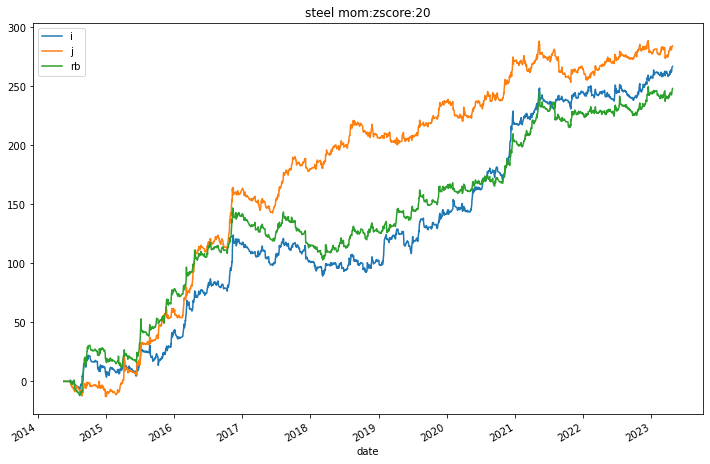

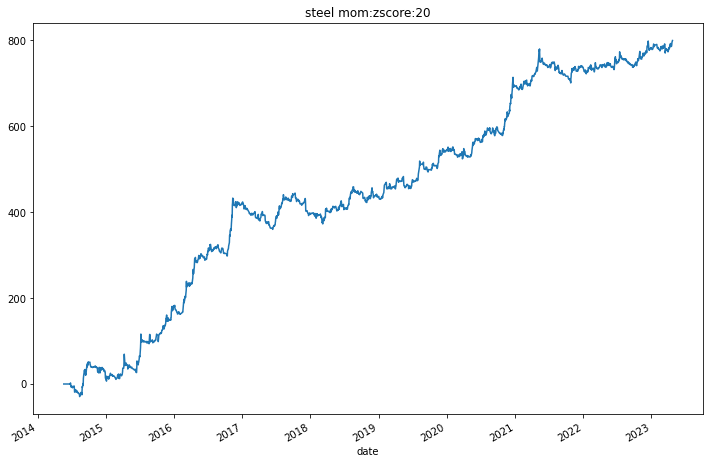

steel mom:qtl:20
i -> SR: 1.41 -- PNL per trade: 62.80 -- Turnover: 33.06
j -> SR: 1.52 -- PNL per trade: 71.83 -- Turnover: 22.89
rb -> SR: 1.25 -- PNL per trade: 47.64 -- Turnover: 21.26
Total SR: 1.55


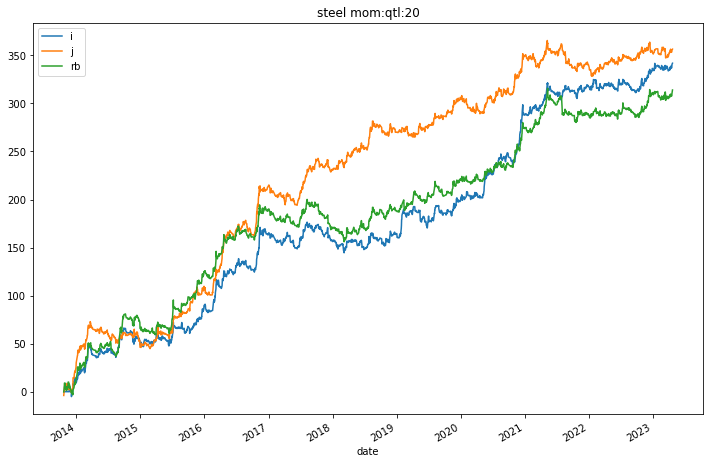

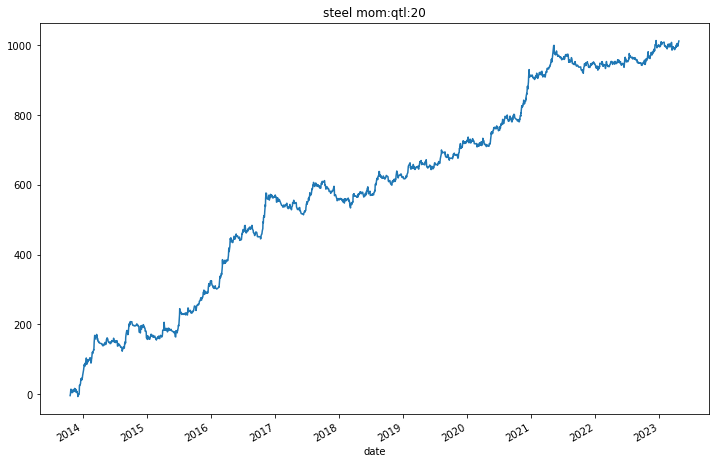

steel mom:zscore:40
i -> SR: 1.32 -- PNL per trade: 89.62 -- Turnover: 25.46
j -> SR: 1.37 -- PNL per trade: 78.57 -- Turnover: 24.76
rb -> SR: 1.15 -- PNL per trade: 53.76 -- Turnover: 25.02
Total SR: 1.46


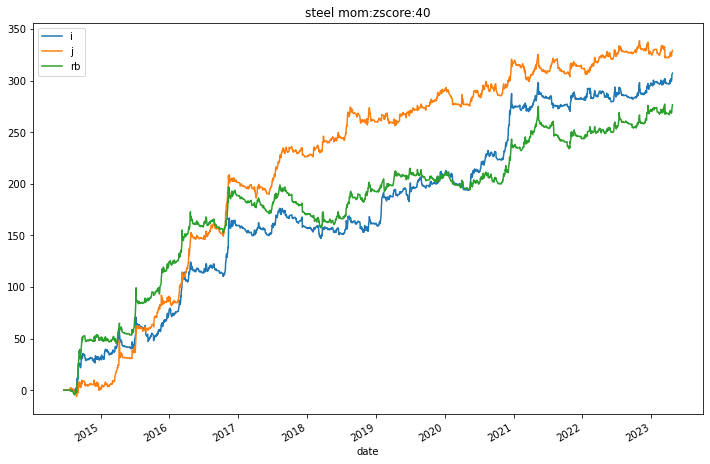

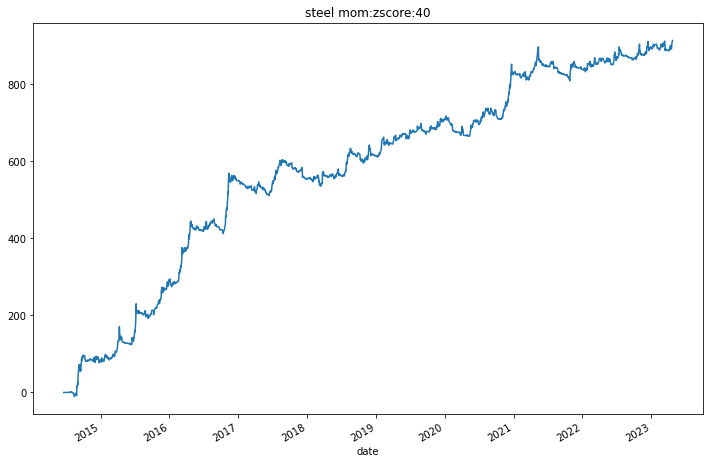

steel mom:qtl:40
i -> SR: 1.42 -- PNL per trade: 93.62 -- Turnover: 22.37
j -> SR: 1.58 -- PNL per trade: 107.05 -- Turnover: 15.87
rb -> SR: 1.28 -- PNL per trade: 69.06 -- Turnover: 15.07
Total SR: 1.59


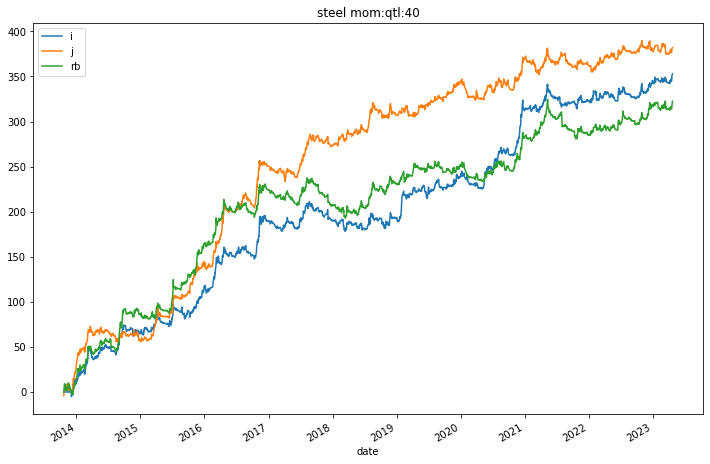

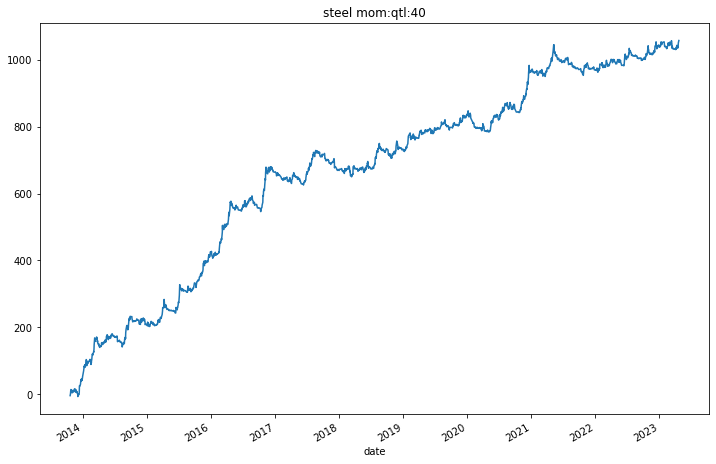

steel mom:zscore:60
i -> SR: 1.36 -- PNL per trade: 117.58 -- Turnover: 20.70
j -> SR: 1.36 -- PNL per trade: 100.00 -- Turnover: 19.77
rb -> SR: 1.19 -- PNL per trade: 72.13 -- Turnover: 20.20
Total SR: 1.48


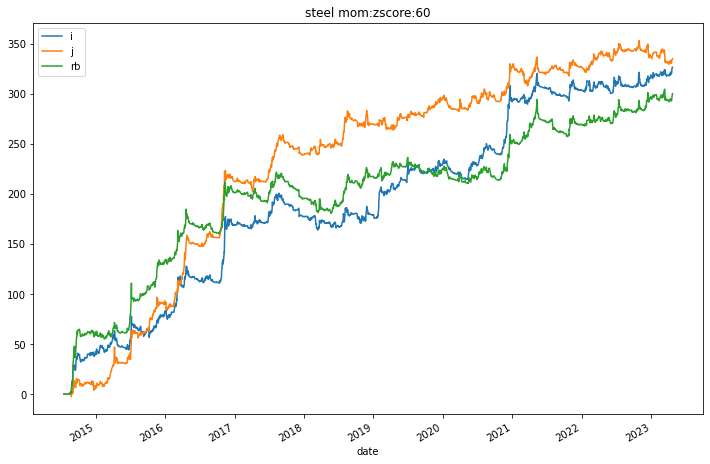

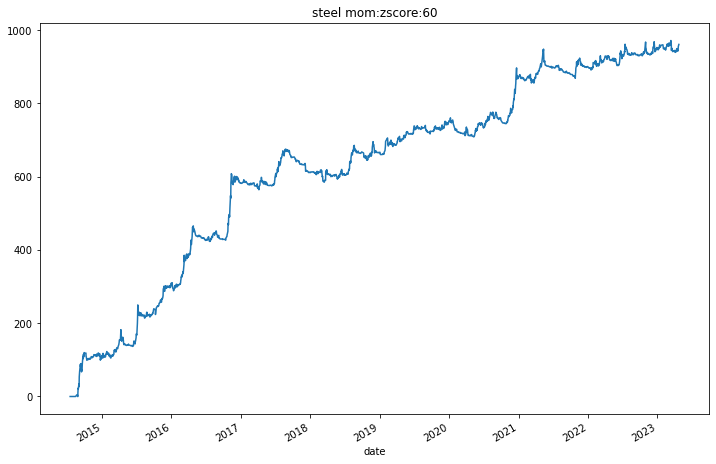

steel mom:qtl:60
i -> SR: 1.42 -- PNL per trade: 113.59 -- Turnover: 18.62
j -> SR: 1.60 -- PNL per trade: 129.44 -- Turnover: 13.32
rb -> SR: 1.30 -- PNL per trade: 83.08 -- Turnover: 12.88
Total SR: 1.62


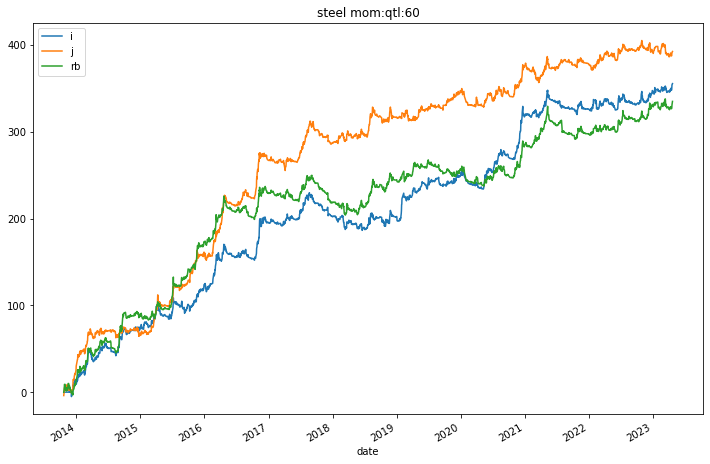

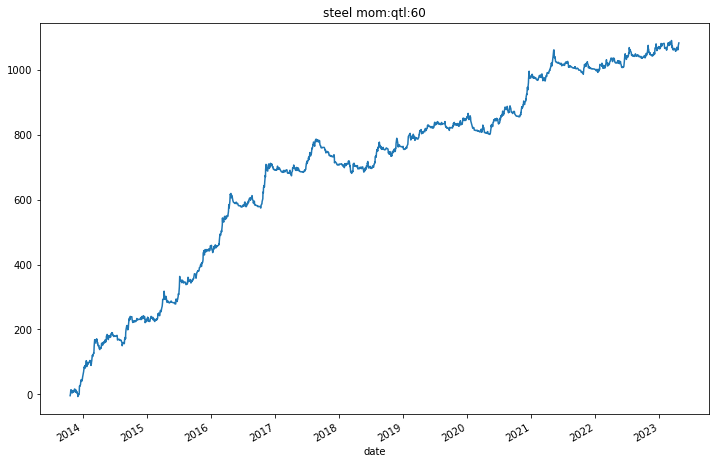

steel mom:zscore:120
i -> SR: 1.02 -- PNL per trade: 124.34 -- Turnover: 14.83
j -> SR: 1.30 -- PNL per trade: 132.54 -- Turnover: 14.48
rb -> SR: 0.88 -- PNL per trade: 74.82 -- Turnover: 14.39
Total SR: 1.21


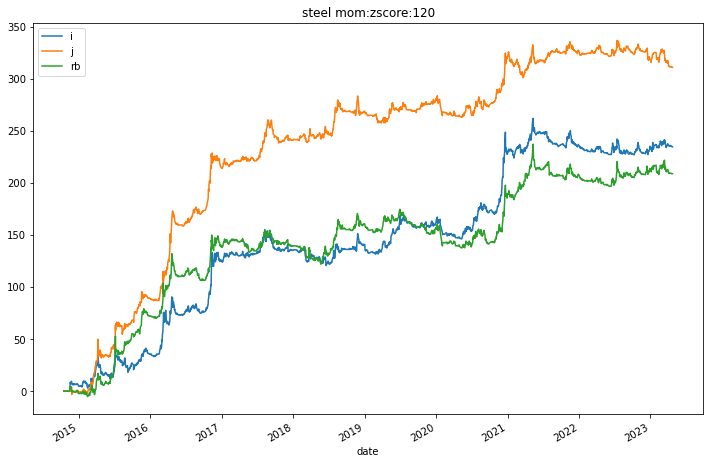

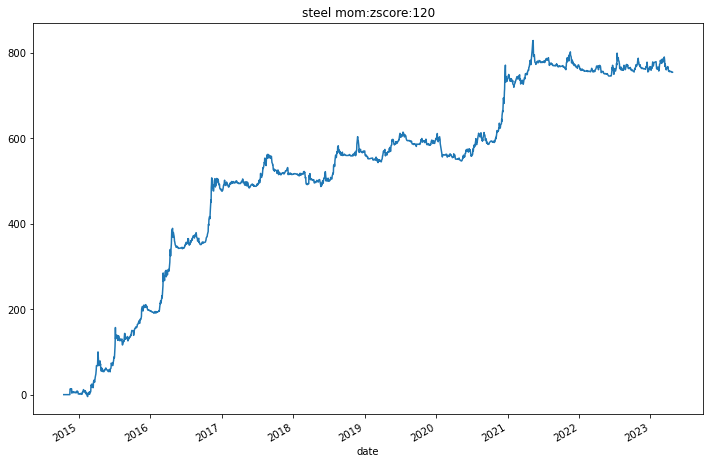

steel mom:qtl:120
i -> SR: 1.35 -- PNL per trade: 152.26 -- Turnover: 12.84
j -> SR: 1.64 -- PNL per trade: 176.04 -- Turnover: 10.25
rb -> SR: 1.36 -- PNL per trade: 116.50 -- Turnover: 9.78
Total SR: 1.61


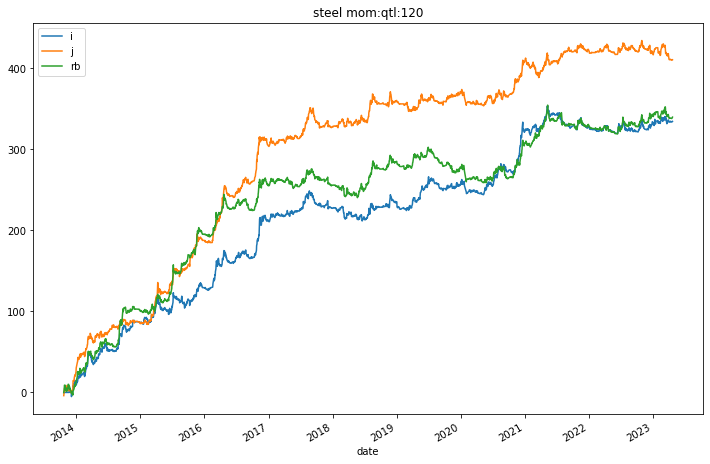

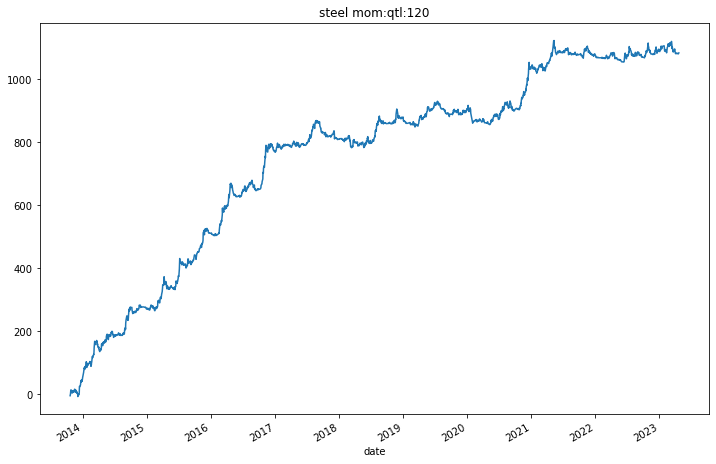

steel mom:zscore:240
i -> SR: 0.81 -- PNL per trade: 133.32 -- Turnover: 10.79
j -> SR: 1.21 -- PNL per trade: 168.21 -- Turnover: 10.83
rb -> SR: 0.89 -- PNL per trade: 100.07 -- Turnover: 10.48
Total SR: 1.11


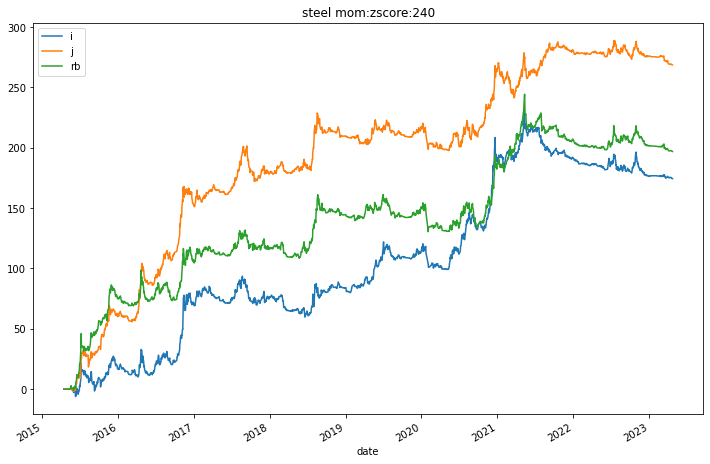

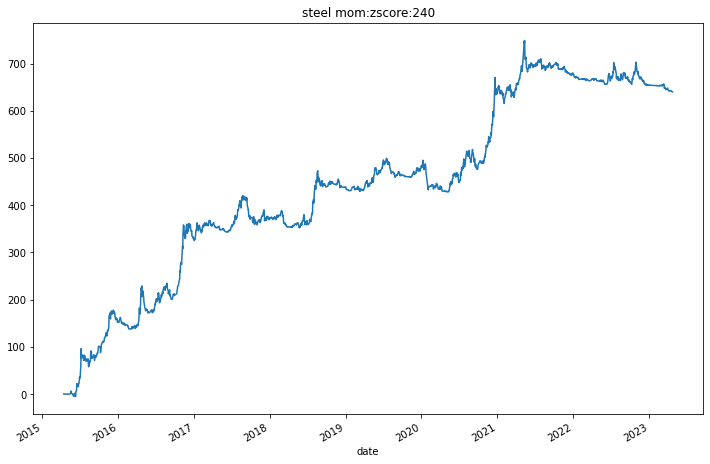

steel mom:qtl:240
i -> SR: 1.21 -- PNL per trade: 192.77 -- Turnover: 9.01
j -> SR: 1.58 -- PNL per trade: 222.21 -- Turnover: 7.88
rb -> SR: 1.30 -- PNL per trade: 144.92 -- Turnover: 7.55
Total SR: 1.55


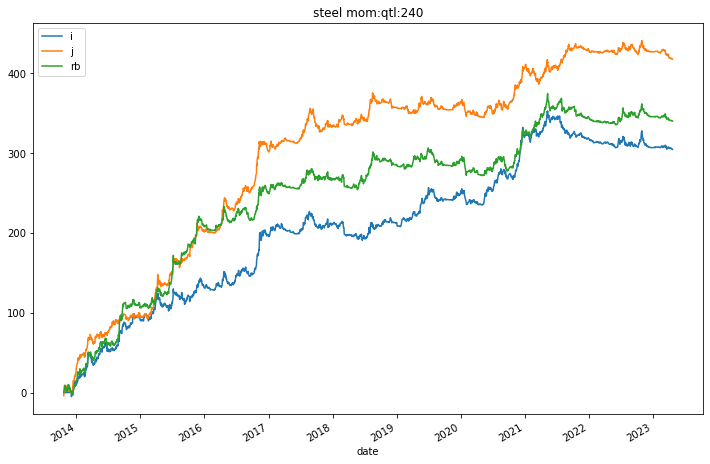

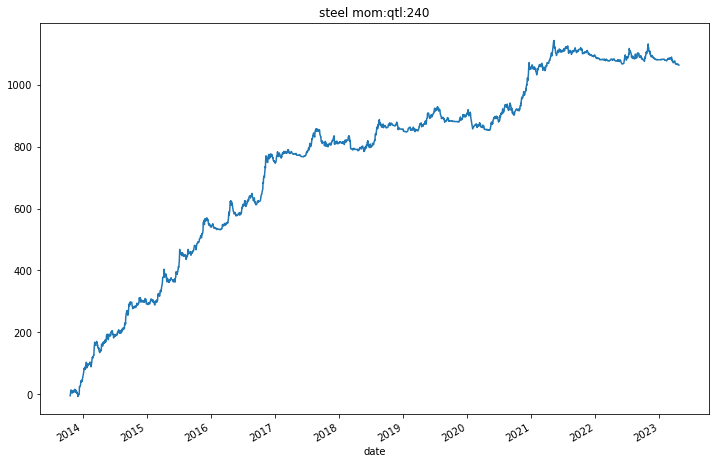

In [23]:
product_list = ['i', 'j', 'rb', ]
cutoff = pd.Timestamp('2012-07-01')

for sig in signal_list:
    print(sig)
    pnl_by_asset = {}
    pnl_df = pd.DataFrame()
    pos_df = pd.DataFrame()
    for asset in product_list:
        signal = signal_raw[sig]
        asset_df = pd.concat([adf[(asset, 'c1', 'close')], signal], axis=1)
        asset_df.columns = ['price', 'signal']
        asset_df = asset_df.dropna(subset=['signal'])
        asset_df['signal'] = asset_df['signal'].apply(lambda x: x).ffill()
        asset_df = asset_df.dropna(subset=['price']).ffill()
        asset_df['position'] = (asset_df['signal']/asset_df['price'].pct_change().rolling(20).std()).shift(1).fillna(0)
        asset_df['pnl'] = (asset_df['position'].shift(1) * asset_df['price'].pct_change()).fillna(0)
        
        sr = np.sqrt(244) * asset_df['pnl'].mean()/asset_df['pnl'].std()
        pnl_per_trade = 100 * 100 * asset_df['pnl'].mean()/asset_df['position'].diff().abs().mean()
        turnover = 100 * asset_df['position'].diff().abs().mean()/asset_df['position'].abs().mean()
        print(f'{asset} -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
        
        pnl_by_asset[asset] = asset_df
        pnl_df[asset] = asset_df['pnl']
        pos_df[asset] = asset_df['position']
    pnl_df = pnl_df.fillna(0)
    pos_df = pos_df.ffill()
    total_sr = np.sqrt(244) * pnl_df.sum(axis=1).mean()/pnl_df.sum(axis=1).std()
    print(f'Total SR: {total_sr:.2f}')
    
    cumpnl = pnl_df.cumsum()
    cumpnl.plot()
    plt.title(sig)
    plt.show()
    cumpnl.sum(axis=1).plot()
    plt.title(sig)
    plt.show()

In [452]:
win =20

#sig_diff = xdf[('hc', 'c1', 'px_chg')] - xdf[('rb', 'c1', 'px_chg')]
#sig_csum = sig_diff.cumsum()
#sig_s1 = (sig_csum - sig_csum.rolling(win).mean())/sig_diff.rolling(win).std()
#sig_s2 = sig_diff.ewm(span=win).mean()/sig_diff.ewm(span=win).std()

feature_ts = df[('fu', 'c1', 'close')]
signal_func = 'qtl'
param_rng = [20, 40, 2]
signal_cap = None
signal_ts = calc_conv_signal(feature_ts.dropna(), signal_func, param_rng, signal_cap=signal_cap)

#sig_up = sig_s2.rolling(244).quantile(0.9)
#sig_dn = sig_s2.rolling(244).quantile(0.1)
#sig_s2 = sig_s2.apply(lambda x: max(min(x, 0.35), -0.35))


In [367]:
signal_func = 'qtl'
param_rng = [10, 11]
signal_cap = None

In [621]:
signal_func = 'qtl'
param_rng = [20, 40, 2]
signal_cap = None

leadlag_port = {
    'ferrous': {'lead': ['hc', 'rb',],
                'lag': ['rb', 'hc', 'i', 'j', 'jm', 'FG', 'SA', 'UR', 'SM', 'SF'],
                'param_rng': [40, 60, 2],
               },
    'base': {'lead': ['al'],
             'lag': ['al', 'ni', 'sn', 'ss', ], # 'zn', 'cu'
             'param_rng': [40, 60, 2],
            },
    'petchem': {'lead': ['v'],
                'lag': ['TA', 'MA', 'pp', 'eg', 'eb', 'PF', ],
                'param_rng': [40, 60, 2],
               },
    'oil': {'lead': ['sc'],
            'lag': ['sc', 'pg', 'bu',],
            'param_rng': [20, 30, 2],
           },
    'bean': {'lead': ['b'],
             'lag': ['p', 'y', 'OI',],
             'param_rng': [60, 80, 2],
            },
}

asset_list = []
for sector in leadlag_port:
    asset_list += leadlag_port[sector]['lag']
    
sig_df = pd.DataFrame(index=df.index, columns=asset_list)
for sector in leadlag_port:
    signal_list = []
    for lead_prod in leadlag_port[sector]['lead']:
        feature_ts = df[(lead_prod, 'c1', 'close')]
        signal_ts = calc_conv_signal(feature_ts.dropna(), signal_func, leadlag_port[sector]['param_rng'], signal_cap=signal_cap)
        signal_list.append(signal_ts)
    signal_ts = pd.concat(signal_list, axis=1).mean(axis=1)
    for lag_prod in leadlag_port[sector]['lag']:
        sig_df[lag_prod] = signal_ts
        
        
input_args = {'product_list': asset_list, 'signal_func': 'zscore'}
leader_lagger(df, input_args)    

,rb,hc,i,j,jm,FG,SA,UR,SM,SF,al,ni,sn,ss,TA,MA,pp,eg,eb,PF,sc,pg,bu,p,y,OI
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-18,-1.195441,-1.195441,-1.195441,-1.195441,-1.195441,-1.195441,-1.195441,0,0,0,1.822587,1.822587,1.822587,1.822587,-0.591983,-0.591983,-0.591983,-0.591983,-0.591983,-0.591983,1.070511,1.070511,1.070511,-0.542631,-0.542631,-0.542631
2023-04-19,-1.378314,-1.378314,-1.378314,-1.378314,-1.378314,-1.378314,-1.378314,0,0,0,1.919859,1.919859,1.919859,1.919859,-0.387233,-0.387233,-0.387233,-0.387233,-0.387233,-0.387233,0.854782,0.854782,0.854782,-1.172482,-1.172482,-1.172482
2023-04-20,-1.534607,-1.534607,-1.534607,-1.534607,-1.534607,-1.534607,-1.534607,0,0,0,2.466897,2.466897,2.466897,2.466897,-0.411021,-0.411021,-0.411021,-0.411021,-0.411021,-0.411021,0.461499,0.461499,0.461499,-1.405826,-1.405826,-1.405826


portfolio sharpe:
%s
 sharpe       1.625576
sharpe_6m    1.041616
sharpe_1y    0.920718
sharpe_2y    1.547397
sharpe_3y    2.155411
sharpe_4y    1.928505
sharpe_5y    1.947828
sharpe_6y    1.819583
sharpe_7y    1.734114
sharpe_8y    1.872622
sharpe_9y    1.823085
Name: total, dtype: float64
asset sharpe:
%s
 product          rb        hc         i         j        jm        FG  \
sharpe     1.050290  0.985909  1.206638  1.225537  0.723042  0.579912   
sharpe_6m  1.557033  1.617879  1.605036  0.262150  0.070551 -0.126245   
sharpe_1y  1.092514  1.289983  0.807677  0.523542  0.557198  0.436664   
sharpe_2y  0.338592  0.654295  0.377962  0.388017  0.792439  0.764232   
sharpe_3y  1.018799  1.511174  1.460643  0.738541  1.010617  1.583013   
sharpe_4y  0.471182  0.901726  1.124035  0.560751  0.620395  0.860065   
sharpe_5y  0.687483  0.891914  1.116008  0.569542  0.437685  0.779785   
sharpe_6y  0.456936  0.704269  0.943093  0.751755  0.465543  0.661219   
sharpe_7y  0.417380  0.602674  0.

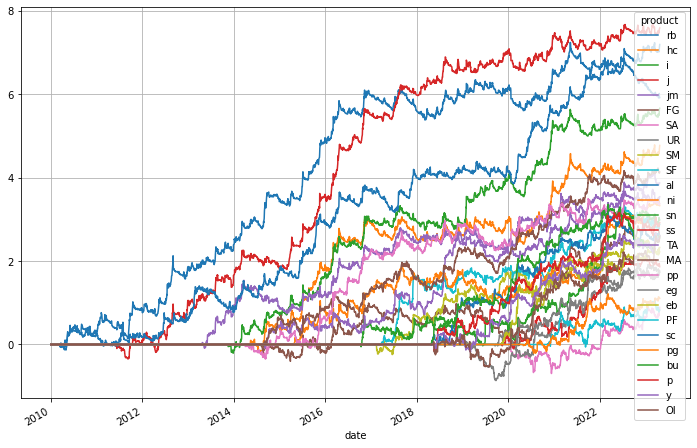

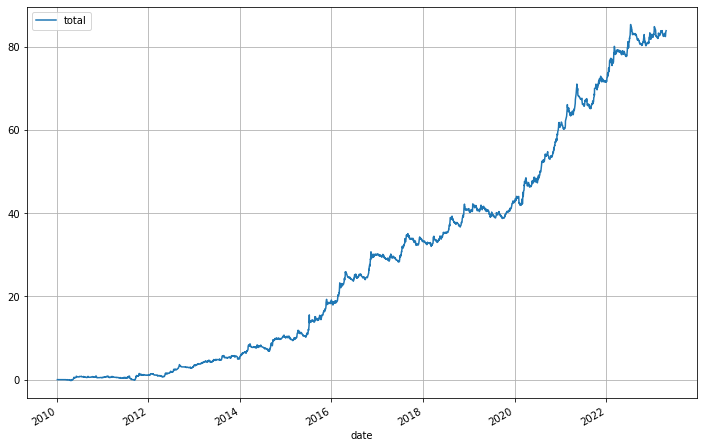

In [622]:
    
vol_win=20
vol_df = get_asset_vols(df, asset_list, vol_win=vol_win, vol_type='pct_chg')

holding = generate_holding_from_signal(sig_df, vol_df,
                                       risk_scaling=1.0,
                                       asset_scaling=False)
df_pxchg = get_px_chg(df, exec_mode='open', chg_type='pct', contract='c1')
df_pxchg = df_pxchg[asset_list].reindex(index=holding.index)

bt_metrics = MetricsBase(holdings=holding[asset_list],
                         returns=df_pxchg[asset_list])

pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y']
pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, use_log_returns=False, tenors=pnl_tenors, perf_metrics=['sharpe', 'std'])
print('portfolio sharpe:\n%s\n', pnl_stats['sharpe'])
print('asset sharpe:\n%s\n', pnl_stats['asset_sharpe_stats'])
print('turnover: %s\n pnl_per_trade: %s\n' % (pnl_stats['turnover'], pnl_stats['pnl_per_trade']))

pnl_stats['asset_cumpnl'].plot()
plt.grid()
plt.show()
pnl_stats['portfolio_cumpnl'].plot()
plt.grid()
plt.show()


In [110]:
pnl_stats

{'asset_pnl': product           TA        MA         l        pp         v        eg  \
 date                                                                     
 2010-01-19       NaN       NaN  0.000000       NaN  0.000000       NaN   
 2010-01-20       NaN       NaN  0.000000       NaN -0.000000       NaN   
 2010-01-21       NaN       NaN  0.000000       NaN -0.000000       NaN   
 2010-01-22       NaN       NaN -0.000000       NaN  0.000000       NaN   
 2010-01-25       NaN       NaN -0.000000       NaN  0.000000       NaN   
 ...              ...       ...       ...       ...       ...       ...   
 2023-04-18  0.064102 -0.009489 -0.065849 -0.057652 -0.240142 -0.036177   
 2023-04-19 -0.029204 -0.011830  0.006124 -0.027569  0.008605 -0.038366   
 2023-04-20 -0.072628  0.107328 -0.025540 -0.037474  0.006519  0.153315   
 2023-04-21 -0.018310  0.013491  0.038455  0.041459  0.000000  0.059696   
 2023-04-24 -0.060677 -0.162591 -0.100915 -0.106168 -0.124185 -0.177402   
 
 product  

In [18]:
print(pnl_stats['portfolio_cumpnl'][-20:], pnl_stats['asset_cumpnl'][-20:])

                total
date                 
2023-03-09  16.396175
2023-03-10  16.372728
2023-03-13  16.374435
2023-03-14  16.388189
2023-03-15  16.280877
2023-03-17  16.347910
2023-03-20  16.326609
2023-03-21  16.298659
2023-03-22  16.310755
2023-03-23  16.226016
2023-03-24  16.381306
2023-03-27  16.469572
2023-03-28  16.464140
2023-03-29  16.457566
2023-03-30  16.434453
2023-03-31  16.427003
2023-04-03  16.392164
2023-04-04  16.278751
2023-04-06  16.254113
2023-04-07  16.302669 product           rb        hc         i         j        jm        cu  \
date                                                                     
2023-03-09  1.669994  1.594187  1.458744  1.300002  1.517703  1.345430   
2023-03-10  1.670114  1.594053  1.457893  1.300468  1.516508  1.343147   
2023-03-13  1.670141  1.595012  1.458337  1.300785  1.517741  1.341120   
2023-03-14  1.672652  1.597693  1.459306  1.298130  1.516442  1.345354   
2023-03-15  1.658943  1.583463  1.452889  1.291433  1.505576  1.333736  

In [54]:
print('turnover stats:\n%s\n', bt_metrics.turnover())

turnover stats:
%s
 {'turnover_perc_y': product             rb          hc           i           j          jm  \
date                                                                     
2014-12-31   70.111957   72.467500   67.982184   67.085574   67.763507   
2015-12-31   88.603635   87.900873   88.976173   89.408592   92.806639   
2016-12-31  111.716362  111.449264  110.531990  112.471470  109.518051   
2017-12-31   83.566089   84.357060   85.411572   83.196729   83.361151   
2018-12-31  106.024678  106.204688  105.938187  106.126107  105.878105   
2019-12-31   96.493910   96.372043   97.240029   96.855571   96.209697   
2020-12-31  100.274976  100.868260  102.933419  101.799930  104.477904   
2021-12-31  116.309615  116.056994  114.627855  119.395469  119.983440   
2022-12-31  106.948288  106.607693  107.977346  108.170683  107.701189   
2023-12-31   30.235226   30.207956   30.237611   30.290618   30.217342   

product             cu          al          zn           v          UR 

C:\dev\pyktrader3\pycmqlib3\analytics\tstool.py:124: RuntimeWarning: invalid value encountered in multiply
  nd_out = np.empty(nd_in.shape) * np.NaN


In [27]:
print(pnl_stats['std']*100000)
print(pnl_stats['portfolio_cumpnl'].tail(20)*100000)
print(bt_metrics.holdings.tail(20)*100000)

std       10860.928790
std_6m    10215.007955
std_1y    10370.542335
std_2y    10030.303730
std_3y    11163.899480
std_4y    10648.438699
std_5y    10572.461585
std_6y    10813.490666
std_7y    10884.410076
std_8y    11071.041370
std_9y    10860.928790
Name: total, dtype: float64
                total
date                 
2023-02-10  25.184076
2023-02-13  25.028260
2023-02-14  25.148438
2023-02-15  25.134642
2023-02-16  25.417362
2023-02-17  25.412789
2023-02-20  25.483284
2023-02-21  25.579566
2023-02-22  25.568283
2023-02-23  25.603782
2023-02-24  25.614752
2023-02-27  25.578018
2023-02-28  25.551430
2023-03-01  25.646932
2023-03-02  25.599062
2023-03-03  25.636538
2023-03-06  25.572613
2023-03-07  25.613203
2023-03-08  25.592952
2023-03-09  25.581344
product            rb         hc           i          j         jm        cu  \
date                                                                           
2023-02-10  35.341497  36.725282  117.430138  36.404032  54.574520  2.58266

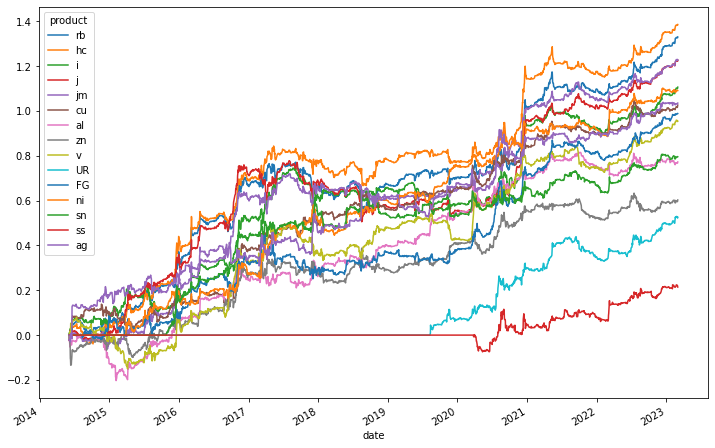

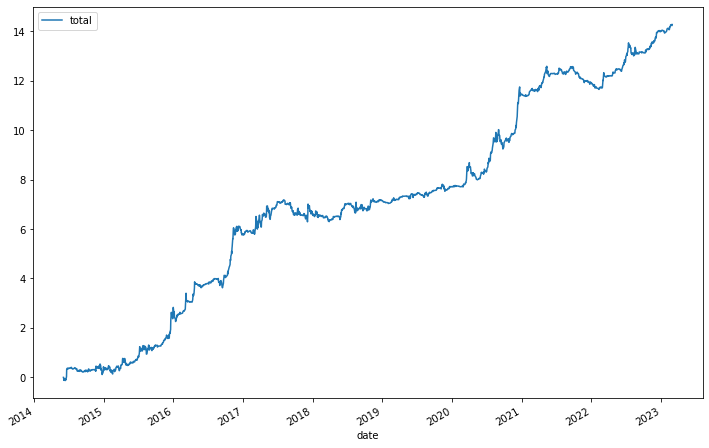

In [465]:
pnl_stats['asset_cumpnl'].plot()
plt.show()


pnl_stats['portfolio_cumpnl'].plot()
plt.show()


# if isinstance(returns, pd.Series):
#             bad_counts = (returns < -1).sum()
#         else:
#             bad_counts = (returns < -1).sum(axis=1)
#         bad_dates = returns.index[bad_counts.values > 0]
#bad_dates = df_pxchg.index[bad_counts.values > 0]

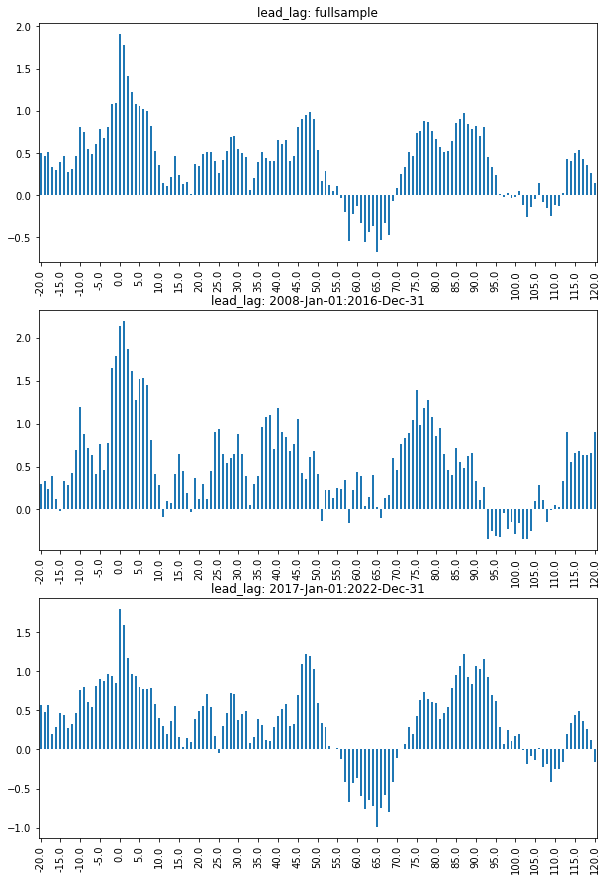

In [348]:
ll_left = lead_lag_config['ll_left']
ll_right = lead_lag_config['ll_right']
spacing = lead_lag_config['ll_spacing']

leadlag_df = bt_metrics.lead_lag(ll_limit_left=ll_left, 
                                 ll_limit_right=ll_right,
                                 ll_sub_windows=lead_lag_config['ll_sub_win'])

fig, ax = plt.subplots(len(ll_keys), 1)
fig.set_figheight(15)
fig.set_figwidth(10)

for i, key in enumerate(ll_keys):
    ts = leadlag_df['leadlag_sharpes'].loc[key]
    ts.plot(kind='bar', ax = ax[i], title = f'lead_lag: {key}')
    new_ticks = np.linspace(ll_left, ll_right, (ll_right-ll_left)//spacing+1)
    ax[i].set_xticks(np.interp(new_ticks, ts.index, np.arange(ts.size)))
    ax[i].set_xticklabels(new_ticks)

plt.show()

# TS signals

In [10]:
fill_backward = False
smooth_win = 1
sig_smooth = tstool.exp_smooth(df_in, hl = smooth_win, fill_backward=fill_backward)

demean = False
mean_win = 244
vol_win = 244
if demean:
    sig_scored = tstool.ts_score(sig_smooth, hl_mean=mean_win, min_obs_mean=mean_win, fill_backward_mean=fill_backward, 
                          hl_vol=vol_win, min_obs_vol=vol_win, fill_backward_vol=fill_backward)
else:
    sig_scored = tstool.ts_scale(sig_smooth, hl = vol_win, min_obs=vol_win, fill_backward=fill_backward)

signal_cap = 2.0

score_capped = tstool.cap(sig_scored, -signal_cap, signal_cap)
score_filled = tstool.filldown(score_capped, 2)
score = tstool.lag(score_filled, 1)


# XS signals

In [ ]:
fill_backward = False
smooth_win = 1
sig_smooth = tstool.exp_smooth(df_in, hl = smooth_win, fill_backward=fill_backward)

demean = True
mean_win = 244
vol_win = 244

sig_scored = tstool.xs_score(sig_smooth, demean=demean, hl=vol_win)

signal_cap = None
if signal_cap:
    sig_scored = tstool.cap(sig_scored, -signal_cap, signal_cap)

score_filled = tstool.filldown(sig_scored, 2)
score = tstool.lag(score_filled, 1)

# scaling signals by vol

In [ ]:
vol_scale = 20
asset_vol = tstool.exp_smooth(df_pxchg**2, hl=vol_scale, fill_backward=fill_backward)**0.5
holding = score/asset_vol

In [11]:
commod_list = holding.columns #['hc']
btmetrics = MetricsBase(holdings = holding[commod_list], returns = df_pxchg[commod_list])


# lead-lag plot

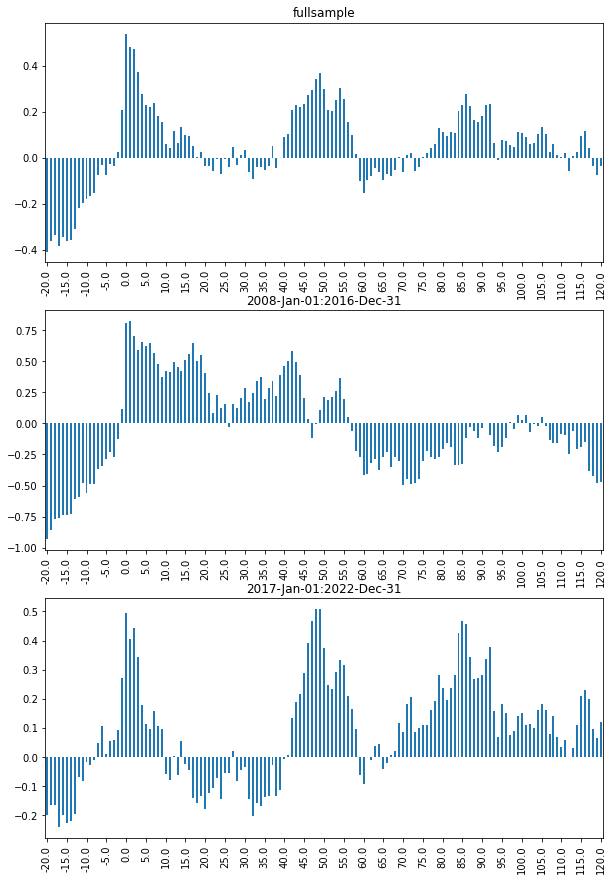

long short PNL stats: total pnl
 {'asset_pnl': product              rb           hc           i            cu            al  \
date                                                                           
2011-01-04          NaN          NaN         NaN           NaN           NaN   
2011-01-05          NaN          NaN         NaN           NaN           NaN   
2011-01-06          NaN          NaN         NaN           NaN           NaN   
2011-01-07          NaN          NaN         NaN           NaN           NaN   
2011-01-10          NaN          NaN         NaN           NaN           NaN   
...                 ...          ...         ...           ...           ...   
2022-12-15  4022.475183 -3298.096214  153.456245    -23.183269      0.000000   
2022-12-16  -425.317885  1279.971079  -64.928470  -1695.953194  -5433.639864   
2022-12-19 -4027.702372  4907.336755 -249.931666    178.950509 -24233.675234   
2022-12-20  1074.430139  -276.212441   62.491073    -90.480659   5761.299

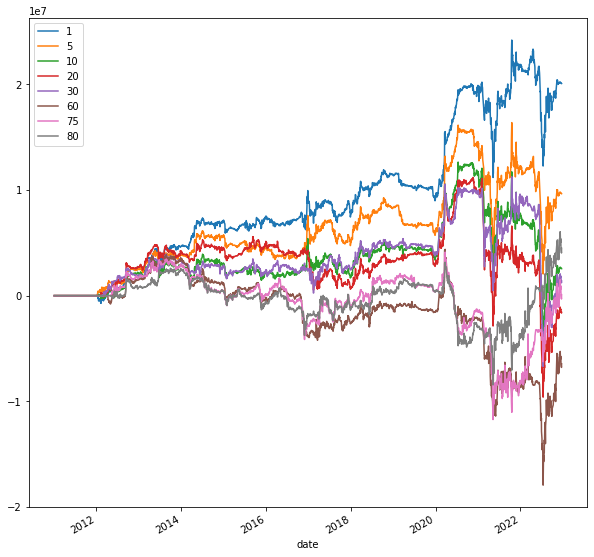

smoothed PNL
                  1         5         10        20        30        60  \
sharpe     0.424388  0.237200  0.148029  0.092113  0.064938  0.013403   
sharpe_fh  0.467961  0.334931  0.242689  0.111928  0.023094 -0.094552   
sharpe_sh  0.449164  0.226516  0.131231  0.099337  0.095688  0.079178   

                 75        80  
sharpe    -0.002124 -0.006365  
sharpe_fh -0.115637 -0.120250  
sharpe_sh  0.071864  0.069724  


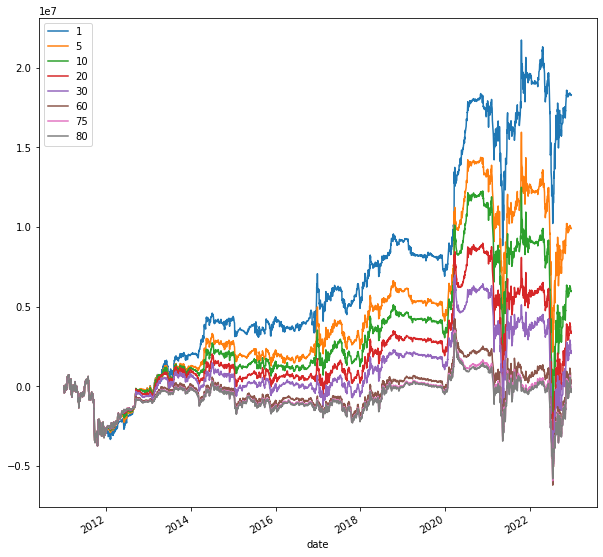

rolling window results: tilt:
 {'asset_pnl': product              rb           hc           i             cu            al  \
date                                                                            
2011-01-04          NaN          NaN         NaN            NaN           NaN   
2011-01-05          NaN          NaN         NaN            NaN           NaN   
2011-01-06          NaN          NaN         NaN            NaN           NaN   
2011-01-07          NaN          NaN         NaN            NaN           NaN   
2011-01-10          NaN          NaN         NaN            NaN           NaN   
...                 ...          ...         ...            ...           ...   
2022-12-15  4094.248375  4814.182067  731.456287 -176157.657403      0.000000   
2022-12-16  -516.208913 -2156.172578 -284.683485 -238257.348558  -6704.824161   
2022-12-19 -4209.442487 -6414.986583 -885.649532  -49334.502674 -22555.267061   
2022-12-20   901.840910   919.020661  211.895160  -16331.278084 

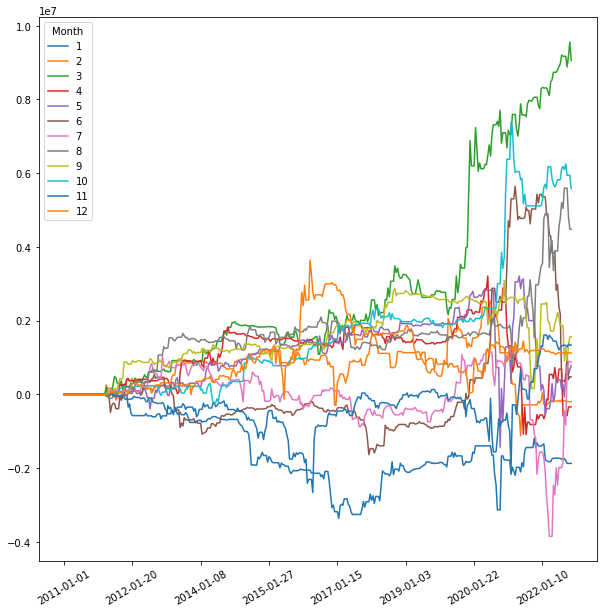

monthday sharpe stats
 MonthDay        1-4     10-14     15-20       5-9       >20
sharpe    -0.281333  0.360488  0.429424  1.196867  2.473581
sharpe_fh  0.062936  0.812157  0.644833  0.845437  2.282985
sharpe_sh -0.437477  0.176575  0.405129  1.540967  2.632124


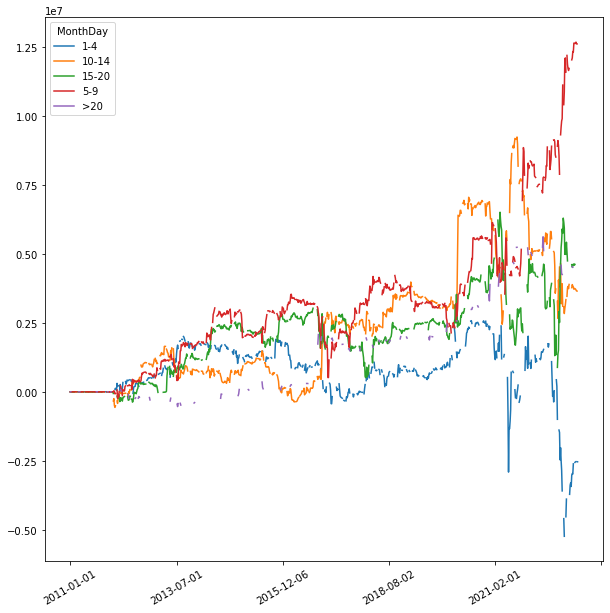

week sharpe stats
 WeekDay           0         1         2         3         4
sharpe     0.127932  1.155465  0.161905 -0.184172  1.453278
sharpe_fh  1.376720  0.889846 -0.037388  0.523738  1.296173
sharpe_sh -0.479939  1.473865  0.348178 -0.471222  1.733000


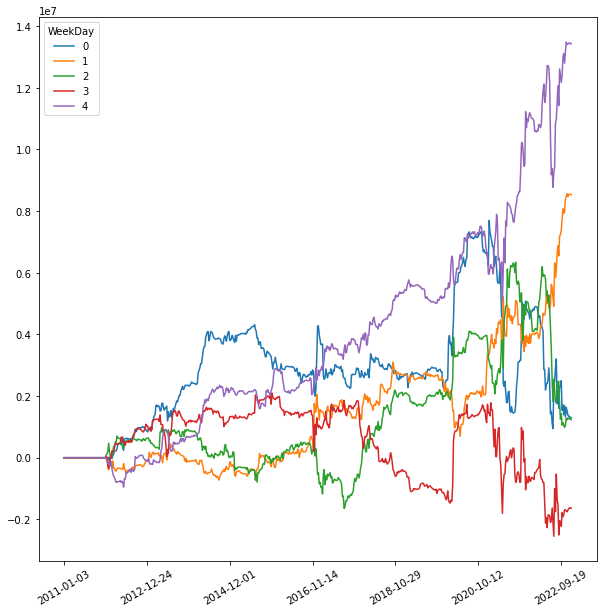

annual sharpe stats
 Year       2011      2012      2013      2014      2015      2016      2017  \
sharpe      NaN  1.283418  1.130351  1.365574  0.174024  0.345670 -0.387149   
sharpe_fh   NaN  0.433570  0.666956  2.435475 -0.455694 -0.942969 -0.136061   
sharpe_sh   NaN  2.838740  1.649217  0.141861  0.483345  0.797757 -0.632676   

Year           2018      2019      2020      2021      2022  
sharpe     1.665705 -1.053999  2.401081  0.172580 -0.089303  
sharpe_fh  1.584175 -1.156773  3.196727 -0.275850 -1.258298  
sharpe_sh  1.890305 -0.963018  1.137854  0.711877  0.864199  


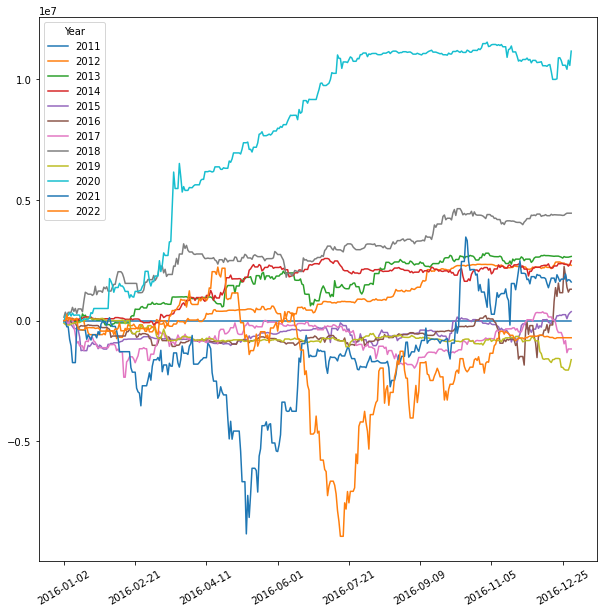

{'turnover_perc_y': product            rb         hc          i         cu         al         zn  \
date                                                                           
2011-12-31        NaN        NaN        NaN        NaN        NaN        NaN   
2012-12-31        NaN        NaN        NaN  55.113879  36.480924  29.965870   
2013-12-31        NaN        NaN        NaN  37.345906  38.348346  59.315684   
2014-12-31  25.291422        NaN        NaN  24.404548  32.087042  36.912701   
2015-12-31  32.700730        NaN  14.923472  26.257785  48.530819  44.274935   
2016-12-31  25.941665        NaN   9.360357  56.841647  26.820105  41.367472   
2017-12-31  16.766814        NaN  17.761120  33.584045  14.310560  39.527163   
2018-12-31  10.216746   6.335120  30.008038  28.539730  22.109552  18.506158   
2019-12-31   7.532250   6.449651   7.571748  47.670131  53.060175  23.879042   
2020-12-31  15.912286  10.932775   9.678882  48.232307  22.384076  33.446817   
2021-12-31  34.00631

In [12]:
ll_left = lead_lag_config['ll_left']
ll_right = lead_lag_config['ll_right']
spacing = lead_lag_config['ll_spacing']

leadlag_df = btmetrics.lead_lag(ll_limit_left=ll_left, 
                                ll_limit_right=ll_right,
                                ll_sub_windows=lead_lag_config['ll_sub_win'])

fig, ax = plt.subplots(len(ll_keys), 1)
fig.set_figheight(15)
fig.set_figwidth(10)

for i, key in enumerate(ll_keys):
    ts = leadlag_df['leadlag_sharpes'].loc[key]
    ts.plot(kind='bar', ax = ax[i], title = f'lead_lag: {key}')
    new_ticks = np.linspace(ll_left, ll_right, (ll_right-ll_left)//spacing+1)
    ax[i].set_xticks(np.interp(new_ticks, ts.index, np.arange(ts.size)))
    ax[i].set_xticklabels(new_ticks)

plt.show()


In [26]:
def display_results(results, desc='', plot_asset = False):
    sharpe = results['sharpe']
    asset_sharpe = results['sharpe']
    print(f"{desc} pnl sharpe:\n{sharpe}\n{asset_sharpe}\n")
    pnl_df = results['portfolio_cumpnl']
    pnl_df.plot(title=f'{desc} cPNL: total')
    plt.show()
    if plot_asset:
        asset_df = results['asset_cumpnl']
        asset_df.plot(title=f'{desc} cPNL by asset')
        plt.show()
    

# long short plot

long short full pnl sharpe:
sharpe       0.540049
sharpe_fh    0.822031
sharpe_sh    0.499458
Name: total, dtype: float64
sharpe       0.540049
sharpe_fh    0.822031
sharpe_sh    0.499458
Name: total, dtype: float64



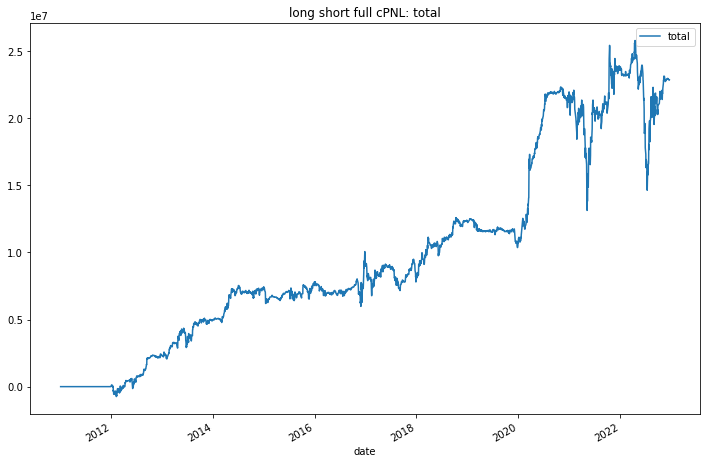

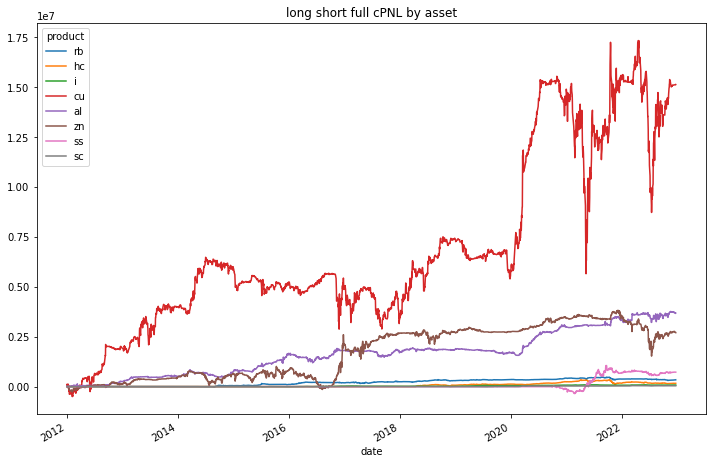

long only pnl sharpe:
sharpe       0.570292
sharpe_fh    0.767055
sharpe_sh    0.560629
Name: total, dtype: float64
sharpe       0.570292
sharpe_fh    0.767055
sharpe_sh    0.560629
Name: total, dtype: float64



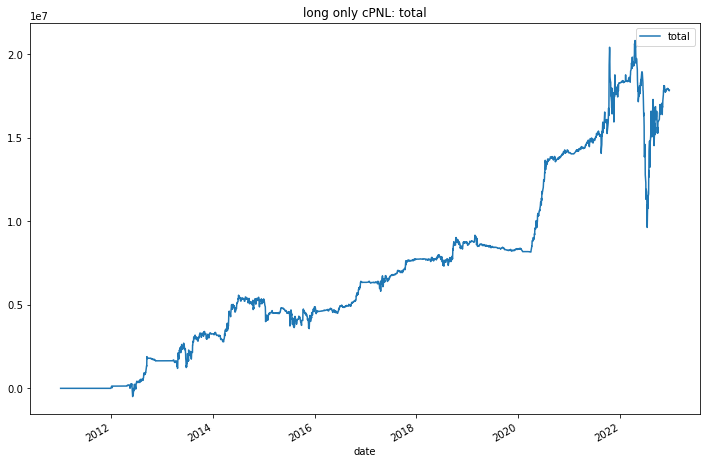

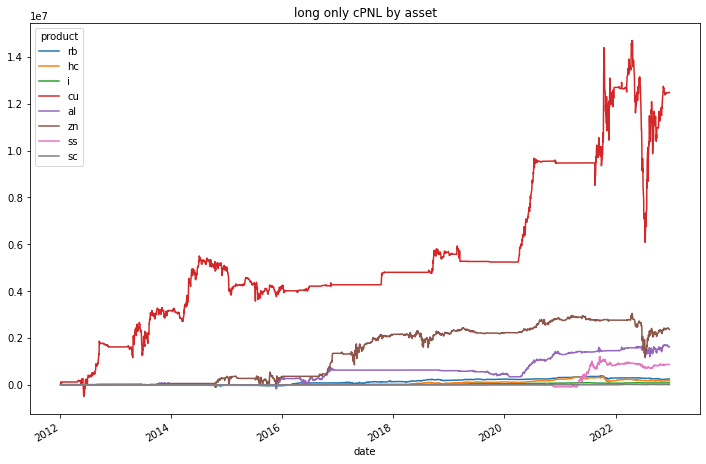

short only pnl sharpe:
sharpe       0.158741
sharpe_fh    0.328653
sharpe_sh    0.114483
Name: total, dtype: float64
sharpe       0.158741
sharpe_fh    0.328653
sharpe_sh    0.114483
Name: total, dtype: float64



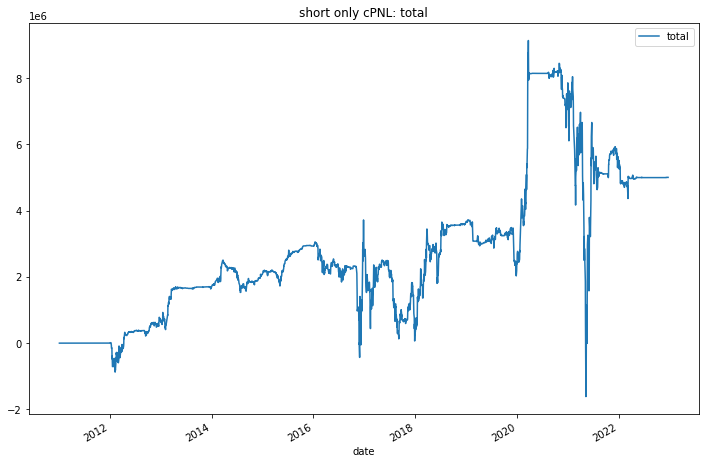

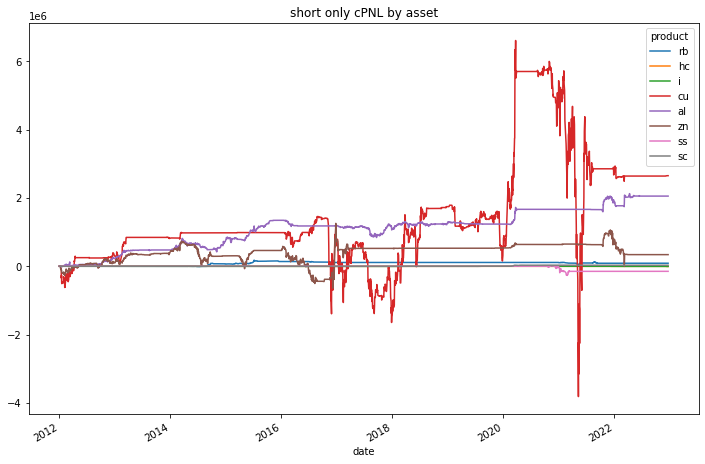

In [36]:
ls_pnl = btmetrics.long_short_pnl()
display_results(ls_pnl['total_pnl_stat'], desc='long short full', plot_asset = True)

display_results(ls_pnl['long_pnl_stat'], desc='long only', plot_asset = True)

display_results(ls_pnl['short_pnl_stat'], desc='short only', plot_asset = True)



# lagged and smoothing

lagged PNL
                  1         5         10        20        30        60  \
sharpe     0.481490  0.227349  0.061205 -0.037099  0.031686 -0.154970   
sharpe_fh  0.836636  0.644449  0.440873  0.404539  0.286068 -0.420536   
sharpe_sh  0.410815  0.117830 -0.053376 -0.172400 -0.034952 -0.091532   

                 75        80  
sharpe     0.002252  0.111715  
sharpe_fh -0.306892 -0.207927  
sharpe_sh  0.109578  0.237270  


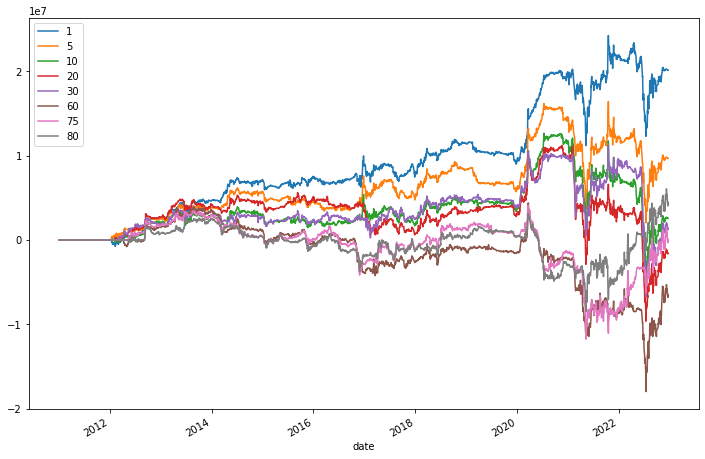

smoothed PNL
                  1         5         10        20        30        60  \
sharpe     0.424388  0.237200  0.148029  0.092113  0.064938  0.013403   
sharpe_fh  0.467961  0.334931  0.242689  0.111928  0.023094 -0.094552   
sharpe_sh  0.449164  0.226516  0.131231  0.099337  0.095688  0.079178   

                 75        80  
sharpe    -0.002124 -0.006365  
sharpe_fh -0.115637 -0.120250  
sharpe_sh  0.071864  0.069724  


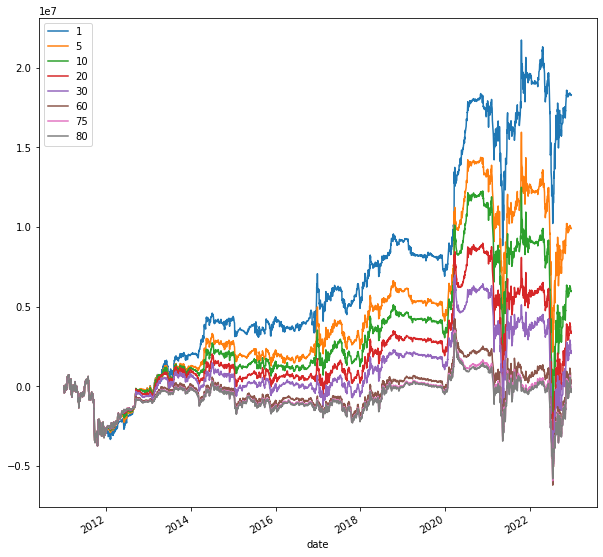

tilt (rolling) pnl sharpe:
sharpe       0.030715
sharpe_fh    0.165156
sharpe_sh   -0.007192
Name: total, dtype: float64
sharpe       0.030715
sharpe_fh    0.165156
sharpe_sh   -0.007192
Name: total, dtype: float64



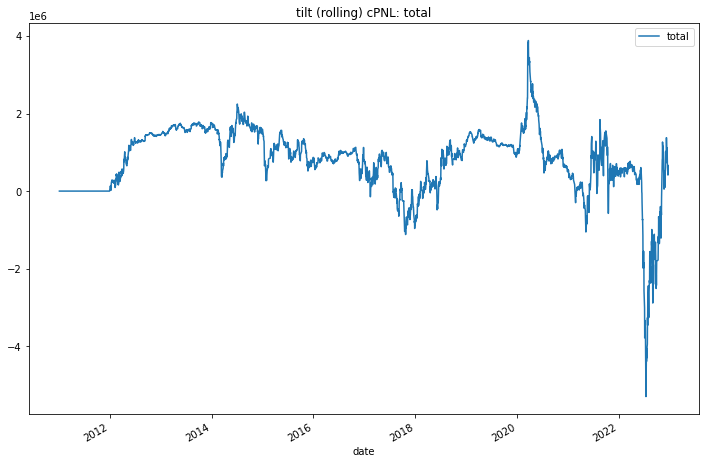

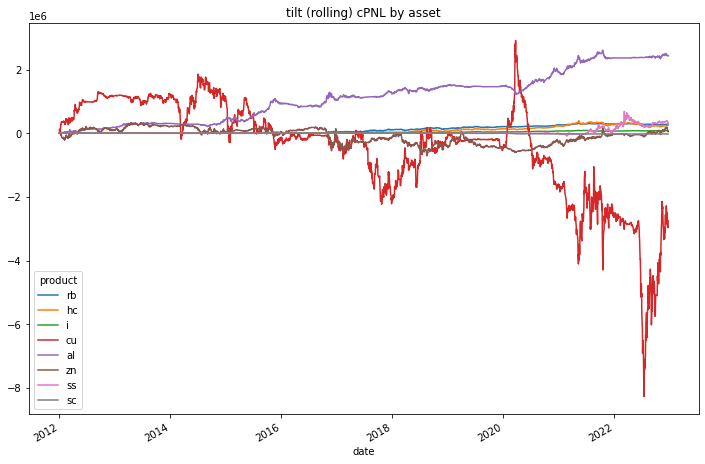

timing (rolling) pnl sharpe:
sharpe       0.600809
sharpe_fh    0.874938
sharpe_sh    0.574219
Name: total, dtype: float64
sharpe       0.600809
sharpe_fh    0.874938
sharpe_sh    0.574219
Name: total, dtype: float64



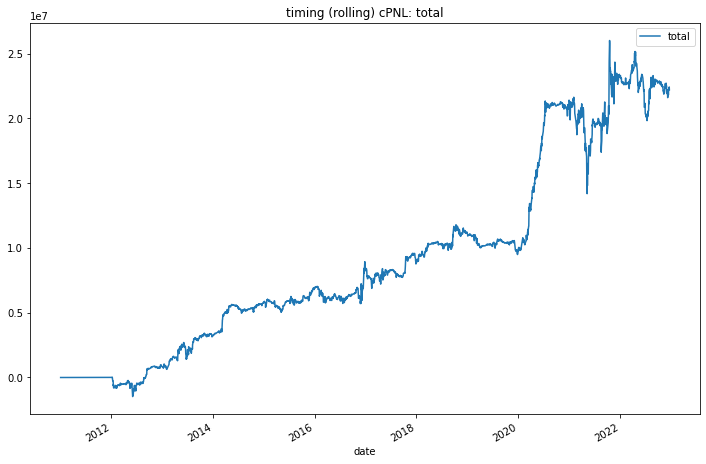

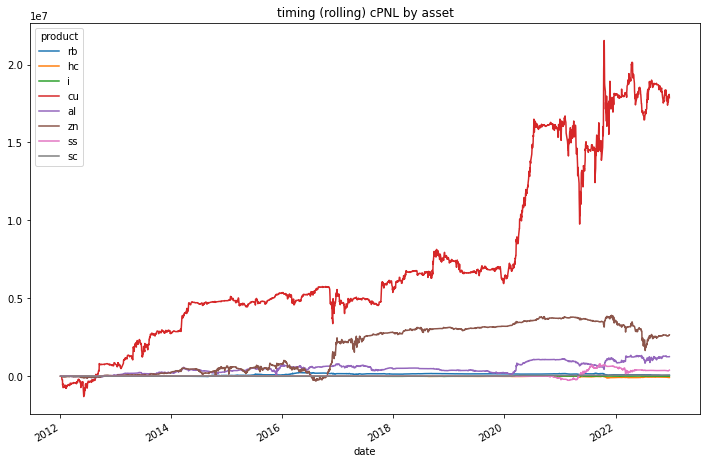

tilt (full sample) pnl sharpe:
sharpe       0.452381
sharpe_fh    0.336041
sharpe_sh    0.569836
Name: total, dtype: float64
sharpe       0.452381
sharpe_fh    0.336041
sharpe_sh    0.569836
Name: total, dtype: float64



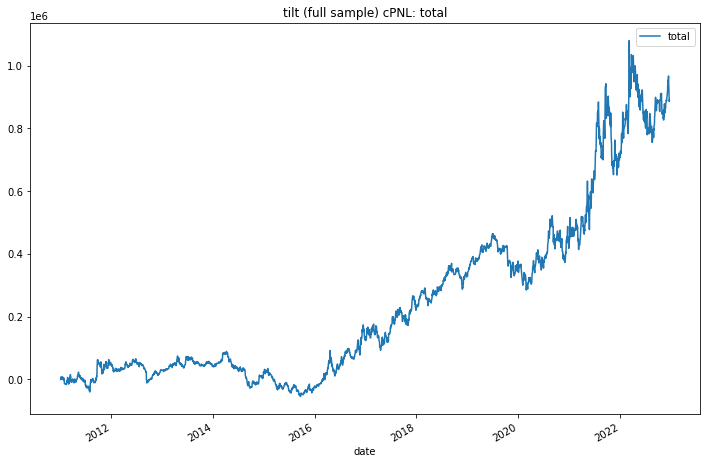

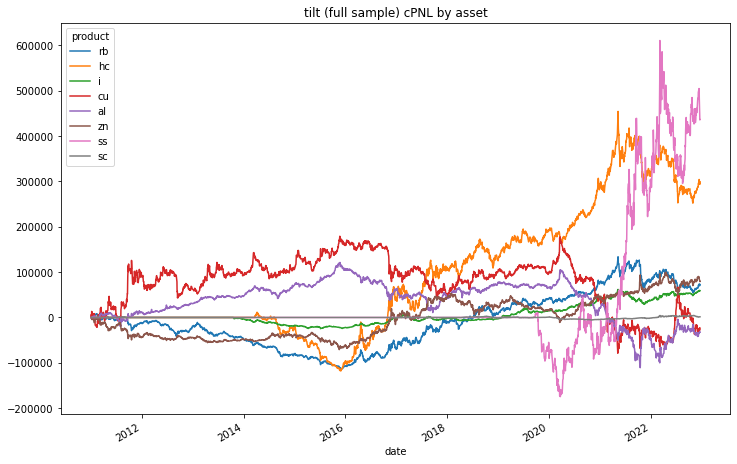

timing (full sample) pnl sharpe:
sharpe       0.521158
sharpe_fh    0.806804
sharpe_sh    0.474923
Name: total, dtype: float64
sharpe       0.521158
sharpe_fh    0.806804
sharpe_sh    0.474923
Name: total, dtype: float64



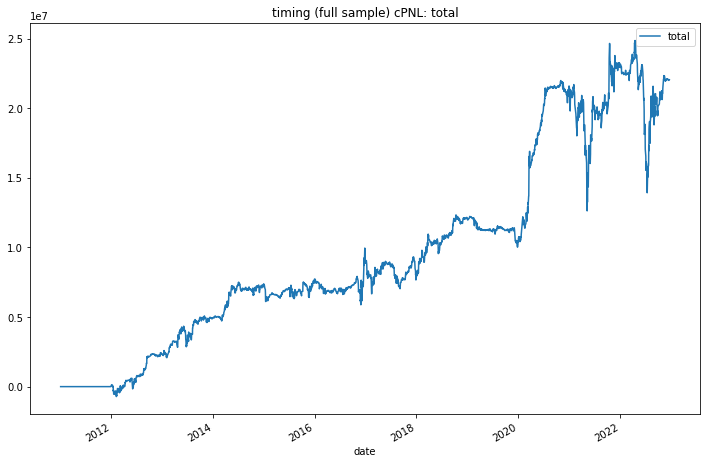

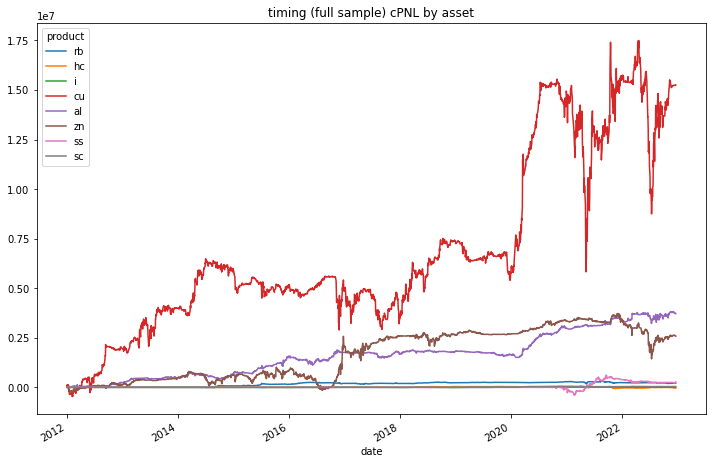

In [37]:
lagged = btmetrics.lagged_pnl(lags=[1, 5, 10, 20, 30, 60, 75, 80])
lagged['cumpnl'].plot()
print('lagged PNL\n', lagged['sharpe'])
plt.show()

smoothed = btmetrics.smoothed_pnl(smooth_hls=[1, 5, 10, 20, 30, 60, 75, 80])
smoothed['cumpnl'].plot(figsize=(10,10))
print('smoothed PNL\n', smoothed['sharpe'])
plt.show()

tilt_timing = btmetrics.tilt_timing(tilt_rolling_window=1*244) # default 3 years  tilt_rolling_window = 3 * 244 
display_results(tilt_timing['pnl_tilt_stat'], desc='tilt (rolling)', plot_asset = True)
display_results(tilt_timing['pnl_timing_stat'], desc='timing (rolling)', plot_asset = True)

display_results(tilt_timing['pnl_tilt_stat_full_sample'], desc='tilt (full sample)', plot_asset = True)
display_results(tilt_timing['pnl_timing_stat_full_sample'], desc='timing (full sample)', plot_asset = True)



# seasonal, month, week, annual pnl pattern

seasonal sharpe stats
 Month            1         2         3         4         5         6   \
sharpe    -0.584977 -0.055566  1.876227 -0.082396  0.135248  0.098579   
sharpe_fh -2.439441  1.130558  1.766893  1.469441  1.500585 -0.318623   
sharpe_sh  0.128620 -0.475357  2.450986 -0.609562 -0.151288  0.257854   

Month            7         8         9         10        11        12  
sharpe     0.178581  0.998385  0.418405  1.408710  0.294433  0.295507  
sharpe_fh -0.023288  2.048576  1.982131  1.752230 -0.512112  1.257678  
sharpe_sh  0.280129  0.825712  0.074509  1.565186  0.803898 -0.982276  


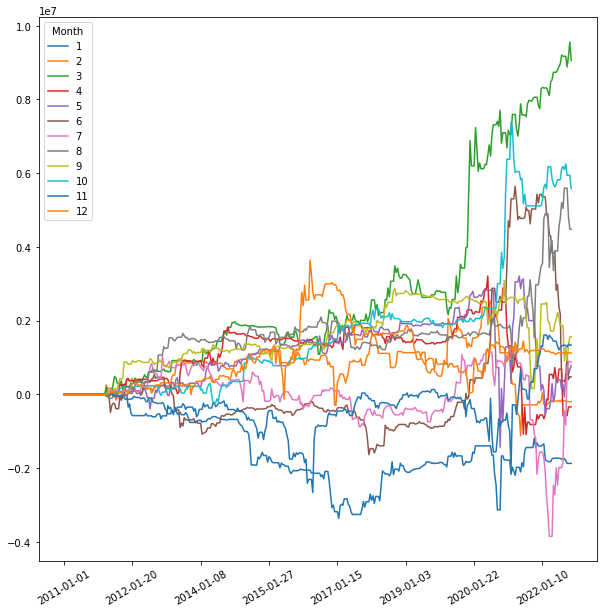

monthday sharpe stats
 MonthDay        1-4     10-14     15-20       5-9       >20
sharpe    -0.281333  0.360488  0.429424  1.196867  2.473581
sharpe_fh  0.062936  0.812157  0.644833  0.845437  2.282985
sharpe_sh -0.437477  0.176575  0.405129  1.540967  2.632124


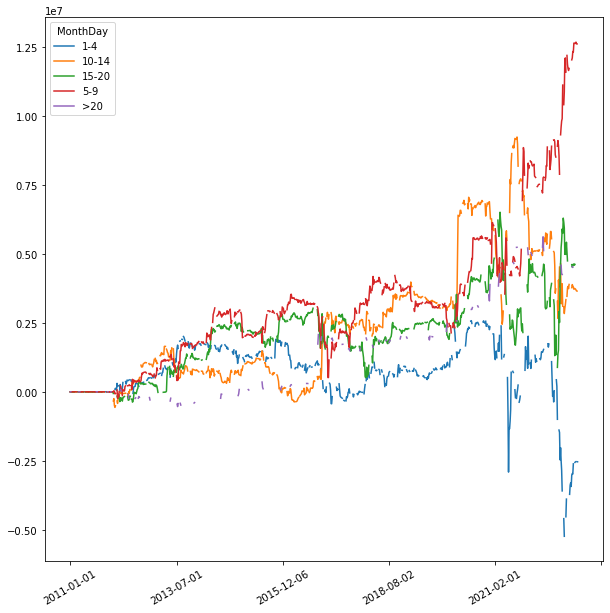

week sharpe stats
 WeekDay           0         1         2         3         4
sharpe     0.127932  1.155465  0.161905 -0.184172  1.453278
sharpe_fh  1.376720  0.889846 -0.037388  0.523738  1.296173
sharpe_sh -0.479939  1.473865  0.348178 -0.471222  1.733000


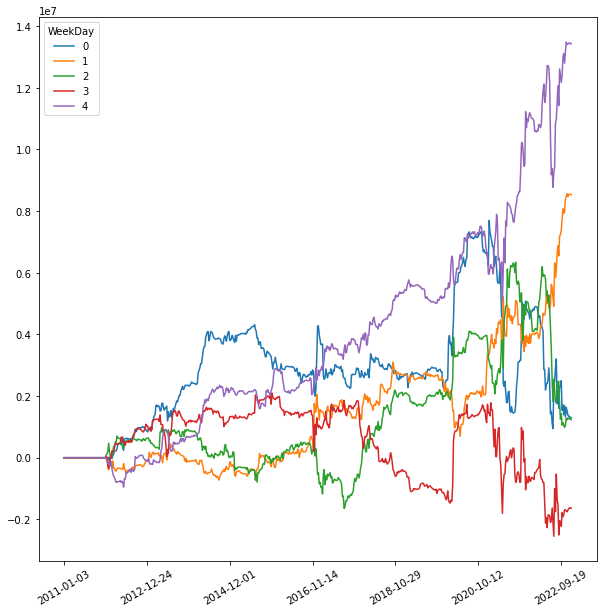

annual sharpe stats
 Year       2011      2012      2013      2014      2015      2016      2017  \
sharpe      NaN  1.283418  1.130351  1.365574  0.174024  0.345670 -0.387149   
sharpe_fh   NaN  0.433570  0.666956  2.435475 -0.455694 -0.942969 -0.136061   
sharpe_sh   NaN  2.838740  1.649217  0.141861  0.483345  0.797757 -0.632676   

Year           2018      2019      2020      2021      2022  
sharpe     1.665705 -1.053999  2.401081  0.172580 -0.089303  
sharpe_fh  1.584175 -1.156773  3.196727 -0.275850 -1.258298  
sharpe_sh  1.890305 -0.963018  1.137854  0.711877  0.864199  


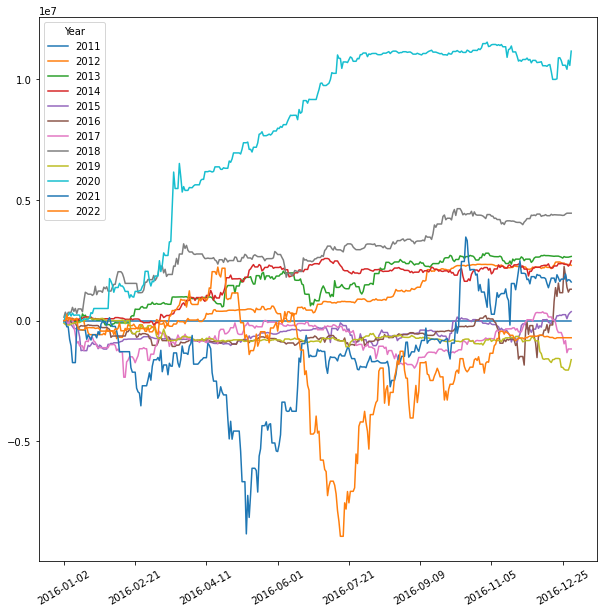

In [40]:
seasonal_pnl = btmetrics.seasonal_pnl()
cumpnl = seasonal_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (10,10))
print('seasonal sharpe stats\n', seasonal_pnl['sharpe_stats'])
plt.show()


monthday_pnl = btmetrics.monthday_pnl()
cumpnl = monthday_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (10,10))
print('monthday sharpe stats\n', monthday_pnl['sharpe_stats'])
plt.show()


week_pnl = btmetrics.week_pnl()
cumpnl = week_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (10,10))
print('week sharpe stats\n', week_pnl['sharpe_stats'])
plt.show()


annual_pnl = btmetrics.annual_pnl()
cumpnl = annual_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (10,10))
print('annual sharpe stats\n', annual_pnl['sharpe_stats'])
plt.show()


In [42]:
turnover = btmetrics.turnover()
print('turnover portfolio perc:\n%s\n' % (turnover['turnover_portfolio_perc_y']))

print('turnover perc by product:\n%s\n' % (turnover['turnover_perc_y']))

print('turnover annual change counts:\n%s\n' % (turnover['change_counts_annual']))

print('turnover monthly change counts:\n%s\n' % (turnover['change_counts_monthly']))

turnover portfolio perc:
date
2011-12-31          NaN
2012-12-31    39.439416
2013-12-31    42.100781
2014-12-31    31.796393
2015-12-31    38.887847
2016-12-31    36.440278
2017-12-31    29.050757
2018-12-31    21.947769
2019-12-31    35.219638
2020-12-31    32.447646
2021-12-31    33.615148
2022-12-31    29.200627
Freq: A-DEC, dtype: float64

turnover perc by product:
product            rb         hc          i         cu         al         zn  \
date                                                                           
2011-12-31        NaN        NaN        NaN        NaN        NaN        NaN   
2012-12-31        NaN        NaN        NaN  55.113879  36.480924  29.965870   
2013-12-31        NaN        NaN        NaN  37.345906  38.348346  59.315684   
2014-12-31  25.291422        NaN        NaN  24.404548  32.087042  36.912701   
2015-12-31  32.700730        NaN  14.923472  26.257785  48.530819  44.274935   
2016-12-31  25.941665        NaN   9.360357  56.841647  26.820105  

C:\dev\pyktrader3\pycmqlib3\analytics\tstool.py:80: RuntimeWarning: invalid value encountered in multiply
  nd_out = np.empty(nd_in.shape) * np.NaN


In [ ]:
sig_df = pd.DataFrame(index=spot_df.index, columns=product_list)
for prodcode in product_list:
    sig_df[prodcode] = spot_df['hc_margin_pbf'] 
    
vol_win=20
vol_df = get_asset_vols(adf, product_list, vol_win=vol_win, vol_type='lret')

holding = generate_holding_from_signal(sig_df, vol_df,
                                       risk_scaling=1.0,
                                       asset_scaling=False)
df_pxchg = get_px_chg(df, exec_mode='open', chg_type='pct', contract='c1')
df_pxchg = df_pxchg[product_list].reindex(index=holding.index)

bt_metrics = MetricsBase(holdings=holding[product_list],
                         returns=df_pxchg[product_list],
                         cost_ratio=0)

pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y']
pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, use_log_returns=True, tenors=pnl_tenors)
print('portfolio sharpe:\n%s\n', pnl_stats['sharpe'])
print('asset sharpe:\n%s\n', pnl_stats['asset_sharpe_stats'])
#print('turnover stats:\n%s\n', bt_metrics.turnover())
pnl_stats['portfolio_cumpnl'].plot()